# Remaking McQuillan Figure 5 🌟

In [2]:
#tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.stats as astat
from solartwins import *
import pickle
from IPython.display import Image, display, HTML
import starspot as ss
import starspot.rotation_tools as rt
from starspot import sigma_clipping
import lightkurve as lk
from lightkurve import search_targetpixelfile, search_lightcurvefile
import math

/Users/ilanadoran/opt/anaconda3/lib/python3.7/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

# McQuillan Autocorrelation Function

In [3]:
# importing data from McQuillan et al 2012
with open('McQuillan_Supplementary_Data/table5.txt', 'r') as f:
    no_rotation_period_txt = f.readlines()
with open('McQuillan_Supplementary_Data/table2.txt', 'r') as f:
    m_dwarf_rotation_period_txt = f.readlines()
with open('McQuillan_Supplementary_Data/table3.txt', 'r') as f:
    giants_txt = f.readlines()
with open('McQuillan_Supplementary_Data/table4.txt', 'r') as f:
    two_periods_txt = f.readlines()

In [4]:
#converting txt files to DataFrames 
m_dwarf_rotation_period = pd.DataFrame([sub.split(",") for sub in m_dwarf_rotation_period_txt])
giants = pd.DataFrame([sub.split(",") for sub in giants_txt])
two_periods = pd.DataFrame([sub.split(",") for sub in two_periods_txt])
no_rotation_period = pd.DataFrame([sub.split(",") for sub in no_rotation_period_txt])

In [5]:
def combining_quarters(star):
    
    # obtaining all 4 quarters 

    mq_KID = 'KIC ' + star
    tpf_lc = search_targetpixelfile(mq_KID).download_all(quality_bitmask='default');
    
    tpf_Q1 = tpf_lc[0].to_lightcurve(aperture_mask=tpf_lc[0].pipeline_mask)
    tpf_Q2 = tpf_lc[1].to_lightcurve(aperture_mask=tpf_lc[1].pipeline_mask)
    tpf_Q3 = tpf_lc[2].to_lightcurve(aperture_mask=tpf_lc[2].pipeline_mask)
    tpf_Q4 = tpf_lc[3].to_lightcurve(aperture_mask=tpf_lc[3].pipeline_mask)

    
    #median-normalizing by quarter
    
    #quarter 1
    med_Q1 = np.median(tpf_Q1.flux)
    flux_normalized_Q1 = tpf_Q1.flux[0:]/med_Q1 - 1
    Q1_time = tpf_Q1.time[0:]
    norm_flux_err_Q1 = tpf_Q1.flux_err[0:]/med_Q1
    
    mask_Q1 = astat.sigma_clip(flux_normalized_Q1, sigma=3, masked = True)
    med_normalized_Q1 = flux_normalized_Q1[~mask_Q1.mask]
    Q1_time = Q1_time[~mask_Q1.mask]
    norm_flux_err_Q1 = norm_flux_err_Q1[~mask_Q1.mask]

    #quarter 2
    med_Q2 = np.median(tpf_Q2.flux)
    flux_normalized_Q2 = tpf_Q2.flux[0:]/med_Q2 - 1
    Q2_time = tpf_Q2.time[0:]
    norm_flux_err_Q2 = tpf_Q2.flux_err[0:]/med_Q2

    mask_Q2 = astat.sigma_clip(flux_normalized_Q2, sigma=3, masked = True)
    med_normalized_Q2 = flux_normalized_Q2[~mask_Q2.mask]
    Q2_time = Q2_time[~mask_Q2.mask]
    norm_flux_err_Q2 = norm_flux_err_Q2[~mask_Q2.mask]

    #combining Q1 and Q2
    Q1_Q2_flux = np.append(med_normalized_Q1, med_normalized_Q2)
    Q1_Q2_time = np.append(Q1_time, Q2_time)
    Q1_Q2_flux_err = np.append(norm_flux_err_Q1, norm_flux_err_Q2)

    #quarter 3
    med_Q3 = np.median(tpf_Q3.flux)
    flux_normalized_Q3 = tpf_Q3.flux[0:]/med_Q3 - 1
    Q3_time = tpf_Q3.time[0:]
    norm_flux_err_Q3 = tpf_Q3.flux_err[0:]/med_Q3

    mask_Q3 = astat.sigma_clip(flux_normalized_Q3, sigma=3, masked = True)
    med_normalized_Q3 = flux_normalized_Q3[~mask_Q3.mask]
    Q3_time = Q3_time[~mask_Q3.mask]
    norm_flux_err_Q3 = norm_flux_err_Q3[~mask_Q3.mask]

    #combining Q1 - Q3
    Q1_Q3_flux = np.append(Q1_Q2_flux, med_normalized_Q3)
    Q1_Q3_time = np.append(Q1_Q2_time, Q3_time)
    Q1_Q3_flux_err = np.append(Q1_Q2_flux_err, norm_flux_err_Q3)

    #quarter 4
    med_Q4 = np.median(tpf_Q4.flux)
    flux_normalized_Q4 = tpf_Q4.flux[0:]/med_Q4 - 1
    Q4_time = tpf_Q4.time[0:]
    norm_flux_err_Q4 = tpf_Q4.flux_err[0:]/med_Q4

    mask_Q4 = astat.sigma_clip(flux_normalized_Q4, sigma=3, masked = True)
    med_normalized_Q4 = flux_normalized_Q4[~mask_Q4.mask]
    Q4_time = Q4_time[~mask_Q4.mask]
    norm_flux_err_Q4 = norm_flux_err_Q4[~mask_Q4.mask]

    #combining Q1 - Q4
    Q1_Q4_flux = np.append(Q1_Q3_flux, med_normalized_Q4)
    Q1_Q4_time = np.append(Q1_Q3_time, Q4_time)
    Q1_Q4_flux_err = np.append(Q1_Q3_flux_err, norm_flux_err_Q4)

    return(Q1_Q4_flux, Q1_Q4_time, Q1_Q4_flux_err)

In [6]:
def combining_tess_quarters(ra_dec): # RA and Dec in string form, ex. "19:20:31.812+40:05:30.23"
    
    search_result = lk.search_targetpixelfile(target = ra_dec, mission='TESS')
    tpf_lc = search_result.download_all(quality_bitmask='default')
        
    tpf_Q1 = tpf_lc[0].to_lightcurve(aperture_mask=tpf_lc[0].pipeline_mask)
    tpf_Q2 = tpf_lc[1].to_lightcurve(aperture_mask=tpf_lc[1].pipeline_mask)
    
    #median-normalizing by quarter
    
    #quarter 1
    
    flux_nans_Q1 = tpf_Q1.flux[0:]
    Q1_time = tpf_Q1.time[0:]
    norm_flux_err_Q1 = tpf_Q1.flux_err[0:]
    
    flux_mask_Q1 = astat.sigma_clip(flux_nans_Q1, sigma=3, masked = True)
    flux_Q1 = flux_nans_Q1[~flux_mask_Q1.mask]
    Q1_time = Q1_time[~flux_mask_Q1.mask]
    flux_err_Q1 = norm_flux_err_Q1[~flux_mask_Q1.mask]
    
    med_Q1 = np.median(flux_Q1)
    flux_normalized_Q1 = flux_Q1[0:]/med_Q1 - 1
    norm_flux_err_Q1 = flux_err_Q1[0:]/med_Q1

    #quarter 2
    
    flux_nans_Q2 = tpf_Q2.flux[0:]
    Q2_time = tpf_Q2.time[0:]
    norm_flux_err_Q2 = tpf_Q2.flux_err[0:]
    
    flux_mask_Q2 = astat.sigma_clip(flux_nans_Q2, sigma=3, masked = True)
    flux_Q2 = flux_nans_Q2[~flux_mask_Q2.mask]
    Q2_time = Q2_time[~flux_mask_Q2.mask]
    flux_err_Q2 = norm_flux_err_Q2[~flux_mask_Q2.mask]
    
    med_Q2 = np.median(flux_Q2)
    flux_normalized_Q2 = flux_Q2[0:]/med_Q2 - 1
    norm_flux_err_Q2 = flux_err_Q2[0:]/med_Q2
    
    #combining Q1 and Q2
    Q1_Q2_flux = np.append(flux_normalized_Q1, flux_normalized_Q2)
    Q1_Q2_time = np.append(Q1_time, Q2_time)
    Q1_Q2_flux_err = np.append(norm_flux_err_Q1, norm_flux_err_Q2)
    
    return(Q1_Q2_flux, Q1_Q2_time, Q1_Q2_flux_err)

In [7]:
def ac_mq_tess(star_ra_dec, num_points, k = None): 

    varied_k = [] #array of autocorrelated fluxes for a given star with varied lag time 
    
    search_result = lk.search_targetpixelfile(target = star_ra_dec, mission='TESS')
    tpf = search_result.download_all(quality_bitmask='default')
    tess_tpf = tpf[1].to_lightcurve(aperture_mask=tpf[1].pipeline_mask)
    tess_tpf.remove_outliers(sigma=3).bin(binsize=10)
    
    flux = tess_tpf.flux[0:] 
    time = tess_tpf.time[0:]
    flux_bar = np.average(flux)
    
    N = len(flux)
    dt = time[1] - time[0] #cadence
    
    if k is None: 
        k = np.linspace(5, (N/2), num_points, dtype = int) #lag time
    
    flux_bar = np.average(flux)
    
    #equation for McQuillan's AC function
    for i, v in enumerate(k): 
        numerator = []
        for ii in range(N - k[i]): 
            num = (flux[ii]-flux_bar)*(flux[ii + k[i]] - flux_bar)  
            numerator.append(num)
            
        denominator = []
        for jj in range(N):
            den = (flux[jj]-flux_bar)**2
            denominator.append(den)
            
        rk = (np.sum(numerator)/np.sum(denominator))
        varied_k.append(rk)
    
    tau = k * dt

    return varied_k, tau 

In [8]:
def combining_PDC_quarters(star):
    
    # obtaining all 4 quarters 

    mq_KID = 'KIC ' + star
    tpf_lc = search_lightcurvefile(mq_KID).download_all()
    
    tpf_Q1 = tpf_lc[0].PDCSAP_FLUX
    tpf_Q2 = tpf_lc[1].PDCSAP_FLUX
    tpf_Q3 = tpf_lc[2].PDCSAP_FLUX
    tpf_Q4 = tpf_lc[3].PDCSAP_FLUX

    
    #median-normalizing by quarter
    
    #quarter 1
    
    flux_nans_Q1 = tpf_Q1.flux[0:]
    Q1_time = tpf_Q1.time[0:]
    norm_flux_err_Q1 = tpf_Q1.flux_err[0:]
    
    flux_mask_Q1 = astat.sigma_clip(flux_nans_Q1, sigma=3, masked = True)
    flux_Q1 = flux_nans_Q1[~flux_mask_Q1.mask]
    Q1_time = Q1_time[~flux_mask_Q1.mask]
    flux_err_Q1 = norm_flux_err_Q1[~flux_mask_Q1.mask]
    
    med_Q1 = np.median(flux_Q1)
    flux_normalized_Q1 = flux_Q1[0:]/med_Q1 - 1
    norm_flux_err_Q1 = flux_err_Q1[0:]/med_Q1

    #quarter 2
    
    flux_nans_Q2 = tpf_Q2.flux[0:]
    Q2_time = tpf_Q2.time[0:]
    norm_flux_err_Q2 = tpf_Q2.flux_err[0:]
    
    flux_mask_Q2 = astat.sigma_clip(flux_nans_Q2, sigma=3, masked = True)
    flux_Q2 = flux_nans_Q2[~flux_mask_Q2.mask]
    Q2_time = Q2_time[~flux_mask_Q2.mask]
    flux_err_Q2 = norm_flux_err_Q2[~flux_mask_Q2.mask]
    
    med_Q2 = np.median(flux_Q2)
    flux_normalized_Q2 = flux_Q2[0:]/med_Q2 - 1
    norm_flux_err_Q2 = flux_err_Q2[0:]/med_Q2
    
    #combining Q1 and Q2
    Q1_Q2_flux = np.append(flux_normalized_Q1, flux_normalized_Q2)
    Q1_Q2_time = np.append(Q1_time, Q2_time)
    Q1_Q2_flux_err = np.append(norm_flux_err_Q1, norm_flux_err_Q2)

    #quarter 3
    
    flux_nans_Q3 = tpf_Q3.flux[0:]
    Q3_time = tpf_Q3.time[0:]
    norm_flux_err_Q3 = tpf_Q3.flux_err[0:]
    
    flux_mask_Q3 = astat.sigma_clip(flux_nans_Q3, sigma=3, masked = True)
    flux_Q3 = flux_nans_Q3[~flux_mask_Q3.mask]
    Q3_time = Q3_time[~flux_mask_Q3.mask]
    flux_err_Q3 = norm_flux_err_Q3[~flux_mask_Q3.mask]
    
    med_Q3 = np.median(flux_Q3)
    flux_normalized_Q3 = flux_Q3[0:]/med_Q3 - 1
    norm_flux_err_Q3 = flux_err_Q3[0:]/med_Q3
    
    #combining Q1 and Q3
    Q1_Q3_flux = np.append(Q1_Q2_flux, flux_normalized_Q3)
    Q1_Q3_time = np.append(Q1_Q2_time, Q3_time)
    Q1_Q3_flux_err = np.append(Q1_Q2_flux_err, norm_flux_err_Q3)
    
    #quarter 4
    
    flux_nans_Q4 = tpf_Q4.flux[0:]
    Q4_time = tpf_Q4.time[0:]
    norm_flux_err_Q4 = tpf_Q4.flux_err[0:]
    
    flux_mask_Q4 = astat.sigma_clip(flux_nans_Q4, sigma=3, masked = True)
    flux_Q4 = flux_nans_Q4[~flux_mask_Q4.mask]
    Q4_time = Q4_time[~flux_mask_Q4.mask]
    flux_err_Q4 = norm_flux_err_Q4[~flux_mask_Q4.mask]
    
    med_Q4 = np.median(flux_Q4)
    flux_normalized_Q4 = flux_Q4[0:]/med_Q4 - 1
    norm_flux_err_Q4 = flux_err_Q4[0:]/med_Q4
    
    #combining Q1 and Q4
    Q1_Q4_flux = np.append(Q1_Q3_flux, flux_normalized_Q4)
    Q1_Q4_time = np.append(Q1_Q3_time, Q4_time)
    Q1_Q4_flux_err = np.append(Q1_Q3_flux_err, norm_flux_err_Q4)

    return(Q1_Q4_flux, Q1_Q4_time, Q1_Q4_flux_err)

In [9]:
def ac_mq_Q1_Q4_PDC(star, num_points, k = None): 

    varied_k = [] #array of autocorrelated fluxes for a given star with varied lag time 
    
    flux_time_Q14 = combining_PDC_quarters(star)
    flux = flux_time_Q14[0]
    time = flux_time_Q14[1]
    
    N = len(flux)
    dt = time[1] - time[0] #cadence
    
    if k is None: 
        k = np.linspace(5, (N/2), num_points, dtype = int) #lag time
    
    flux_bar = np.average(flux)
    
    #equation for McQuillan's AC function
    for i, v in enumerate(k): 
        numerator = []
        for ii in range(N - k[i]): 
            num = (flux[ii]-flux_bar)*(flux[ii + k[i]] - flux_bar)  
            numerator.append(num)
            
        denominator = []
        for jj in range(N):
            den = (flux[jj]-flux_bar)**2
            denominator.append(den)
            
        rk = (np.sum(numerator)/np.sum(denominator))
        varied_k.append(rk)
    
    tau = k * dt

    return varied_k, tau 

In [10]:
tess_cadence = 1./24./30.  # TESS 2 minute cadence 

In [11]:
quart = [1,2,3,4]

# Remaking Plot

In [12]:
KIDs = list(m_dwarf_rotation_period[0])

In [13]:
m_dwarf_rotation_period

0     1     2       3       4           5          6       7
0          KID  Teff  logg    Mass  Period  Period_Err  Amplitude  Flag\n
1      1162635  3899  4.62  0.5037  15.509       0.064       10.7    NF\n
2      1430893  3956  4.41  0.5260  17.144       0.046       10.4    NF\n
3      1572802  3990  4.48  0.5394   0.368       0.000       74.8    PB\n
4      1721911  3833  4.58  0.4781  28.403       0.394        3.9    NF\n
...        ...   ...   ...     ...     ...         ...        ...     ...
1566  12646841  3511  4.04  0.3583   3.300       0.030       9.79    NF\n
1567  12688834  3827  4.60  0.4758  19.289       0.087        7.7    NF\n
1568  12689979  3875  4.66  0.4943  29.772       0.516        6.2    NF\n
1569  12691684  3662  4.23  0.4132  38.824      10.378       11.2    NF\n
1570  12784183  3774  4.62  0.4554  18.176       0.017       11.1    NF\n

[1571 rows x 8 columns]

In [14]:
figure_5a = 'KIC 4918333'
figure_5b = 'KIC 9201463'
figure_5c = 'KIC 9488191'
figure_5d = 'KIC 7590933'

In [3]:
Image(url= "https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/mnras/432/2/10.1093_mnras_stt536/3/stt536fig5.jpeg?Expires=1599839955&Signature=iAmjmLxdmGSeJABVsXlRdjArwbURz627lIvS~ZuC~ZKsBut3TEgq4kXeplEHK6SW542u4TxfGkOxAWdibEo4oabjUOd5sZkC2qUaSJGX3uQqQaw5SQMGBZi26ibtJPg6PAbCa~OxhE12Fgj4EQ4HuczsxudT6uyCtQgIcszbC-CjdDDX5KV1AkTAL6cwRxKmjqlERpODWNeS776OHfq-GGvIV0LBu0Z5g3UXN~HKwvVBxTzUkBEKACzJ2Vt7V-mArLl4NUG5LjTrQUS93C2JfUMIwYYnxVXCoHEovKyk-WCF5OVlLVLd-4tQiKAX-6czQydp-b0IpvZOV6lsaK-QLQ__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA", width = 700, height = 1400)

# Kepler Lightcurves for 5a

In [16]:
five_a = search_lightcurvefile(figure_5a, quarter = 1).download()

In [17]:
five_a_SAP = five_a.SAP_FLUX
five_a_PDC = five_a.PDCSAP_FLUX

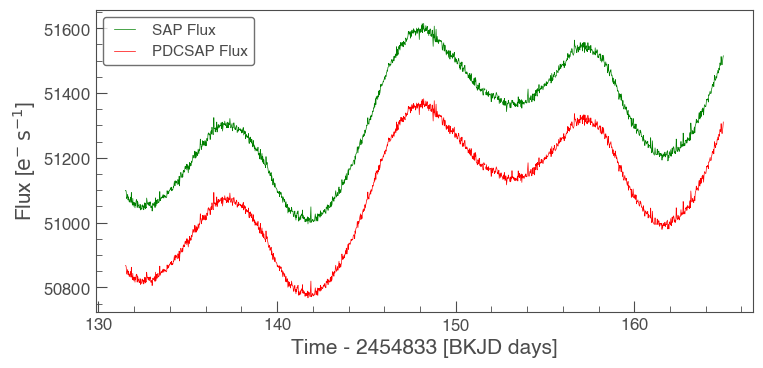

In [18]:
ax = five_a_SAP.plot(label='SAP Flux', color = 'green');
five_a_PDC.plot(label='PDCSAP Flux', color = 'red', ax=ax);

In [19]:
print('The McQuillan ACF is : ', m_dwarf_rotation_period[4][KIDs.index('4918333')])

The McQuillan ACF is :  19.759


In [20]:
figure_five_a = combining_quarters('4918333')
flux_5a = figure_five_a[0]
time_5a = figure_five_a[1]
flux_error_5a = figure_five_a[2]

Text(0, 0.5, 'Normalized Flux')

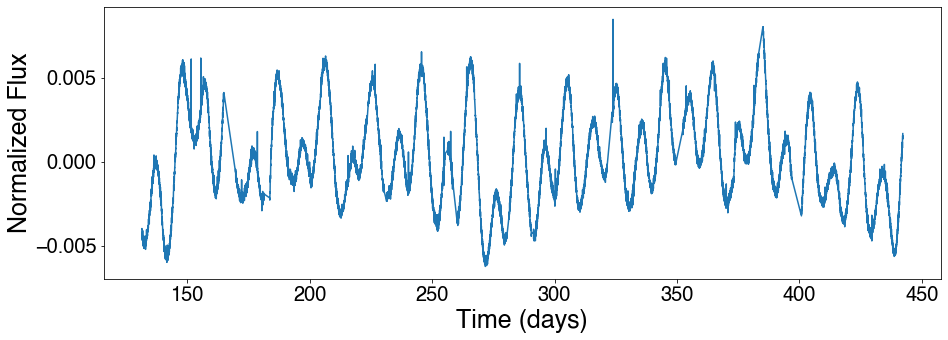

In [21]:
plt.figure(figsize=(15,5))
plt.plot(time_5a, flux_5a)
plt.xlabel('Time (days)')
plt.ylabel('Normalized Flux')

In [22]:
figure_five_a_PDC = combining_PDC_quarters('4918333')
flux_5a_PDC = figure_five_a_PDC[0]
time_5a_PDC = figure_five_a_PDC[1]
flux_error_5a_PDC = figure_five_a_PDC[2]

Text(0, 0.5, 'Normalized Flux')

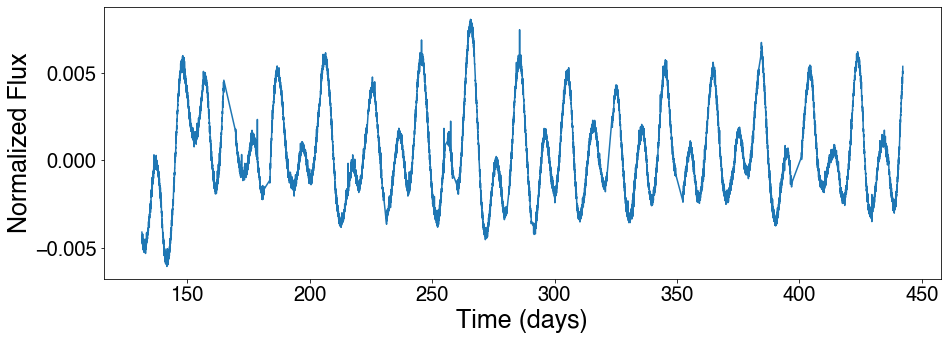

In [23]:
plt.figure(figsize=(15,5))
plt.plot(time_5a_PDC, flux_5a_PDC)
plt.xlabel('Time (days)')
plt.ylabel('Normalized Flux')

In [24]:
acf_fig5a= ac_mq_Q1_Q4_PDC('4918333', 1000);

Text(0.5, 1.0, 'Autocorrelated Figure 5a')

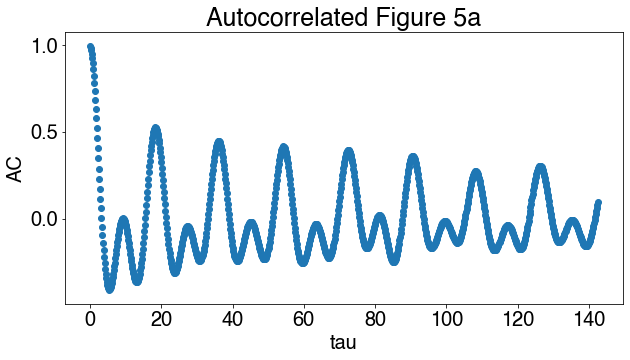

In [25]:
plt.figure(figsize=(10,5))
plt.scatter(acf_fig5a[1], acf_fig5a[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated Figure 5a', fontsize = 25)

In [26]:
rotate_fig5 = ss.RotationModel(time_5a_PDC, flux_5a_PDC, flux_error_5a_PDC)

9.875566616300773


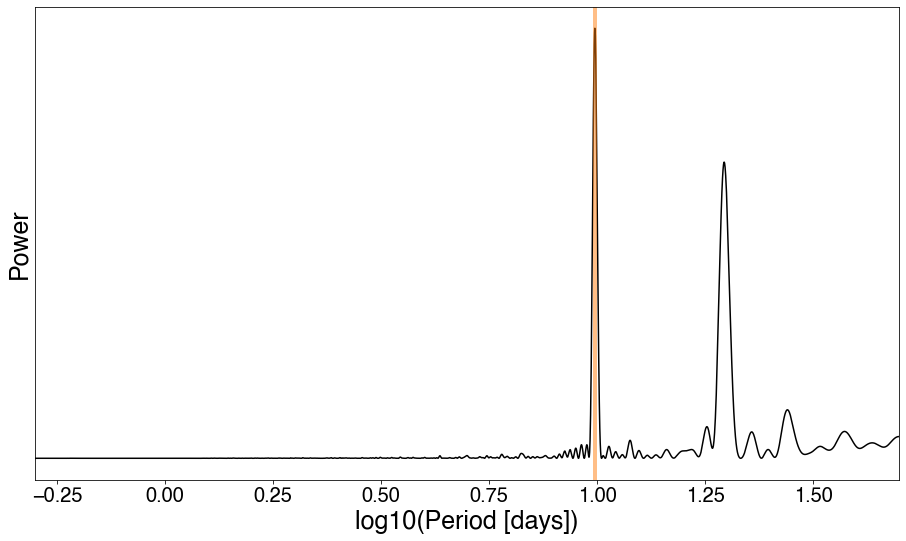

In [27]:
ls_period = rotate_fig5.ls_rotation()
print(ls_period)
rotate_fig5.ls_plot();

In [28]:
period_grid_5a = np.linspace(.1, 10, 1000)
pdm_period_5a, period_err_5a = rotate_fig5.pdm_rotation(period_grid_5a, pdm_nbins=10)
print(pdm_period_5a, period_err_5a)

100%|██████████| 1000/1000 [00:11<00:00, 83.63it/s]


9.881081081081081 0.11205296900195484


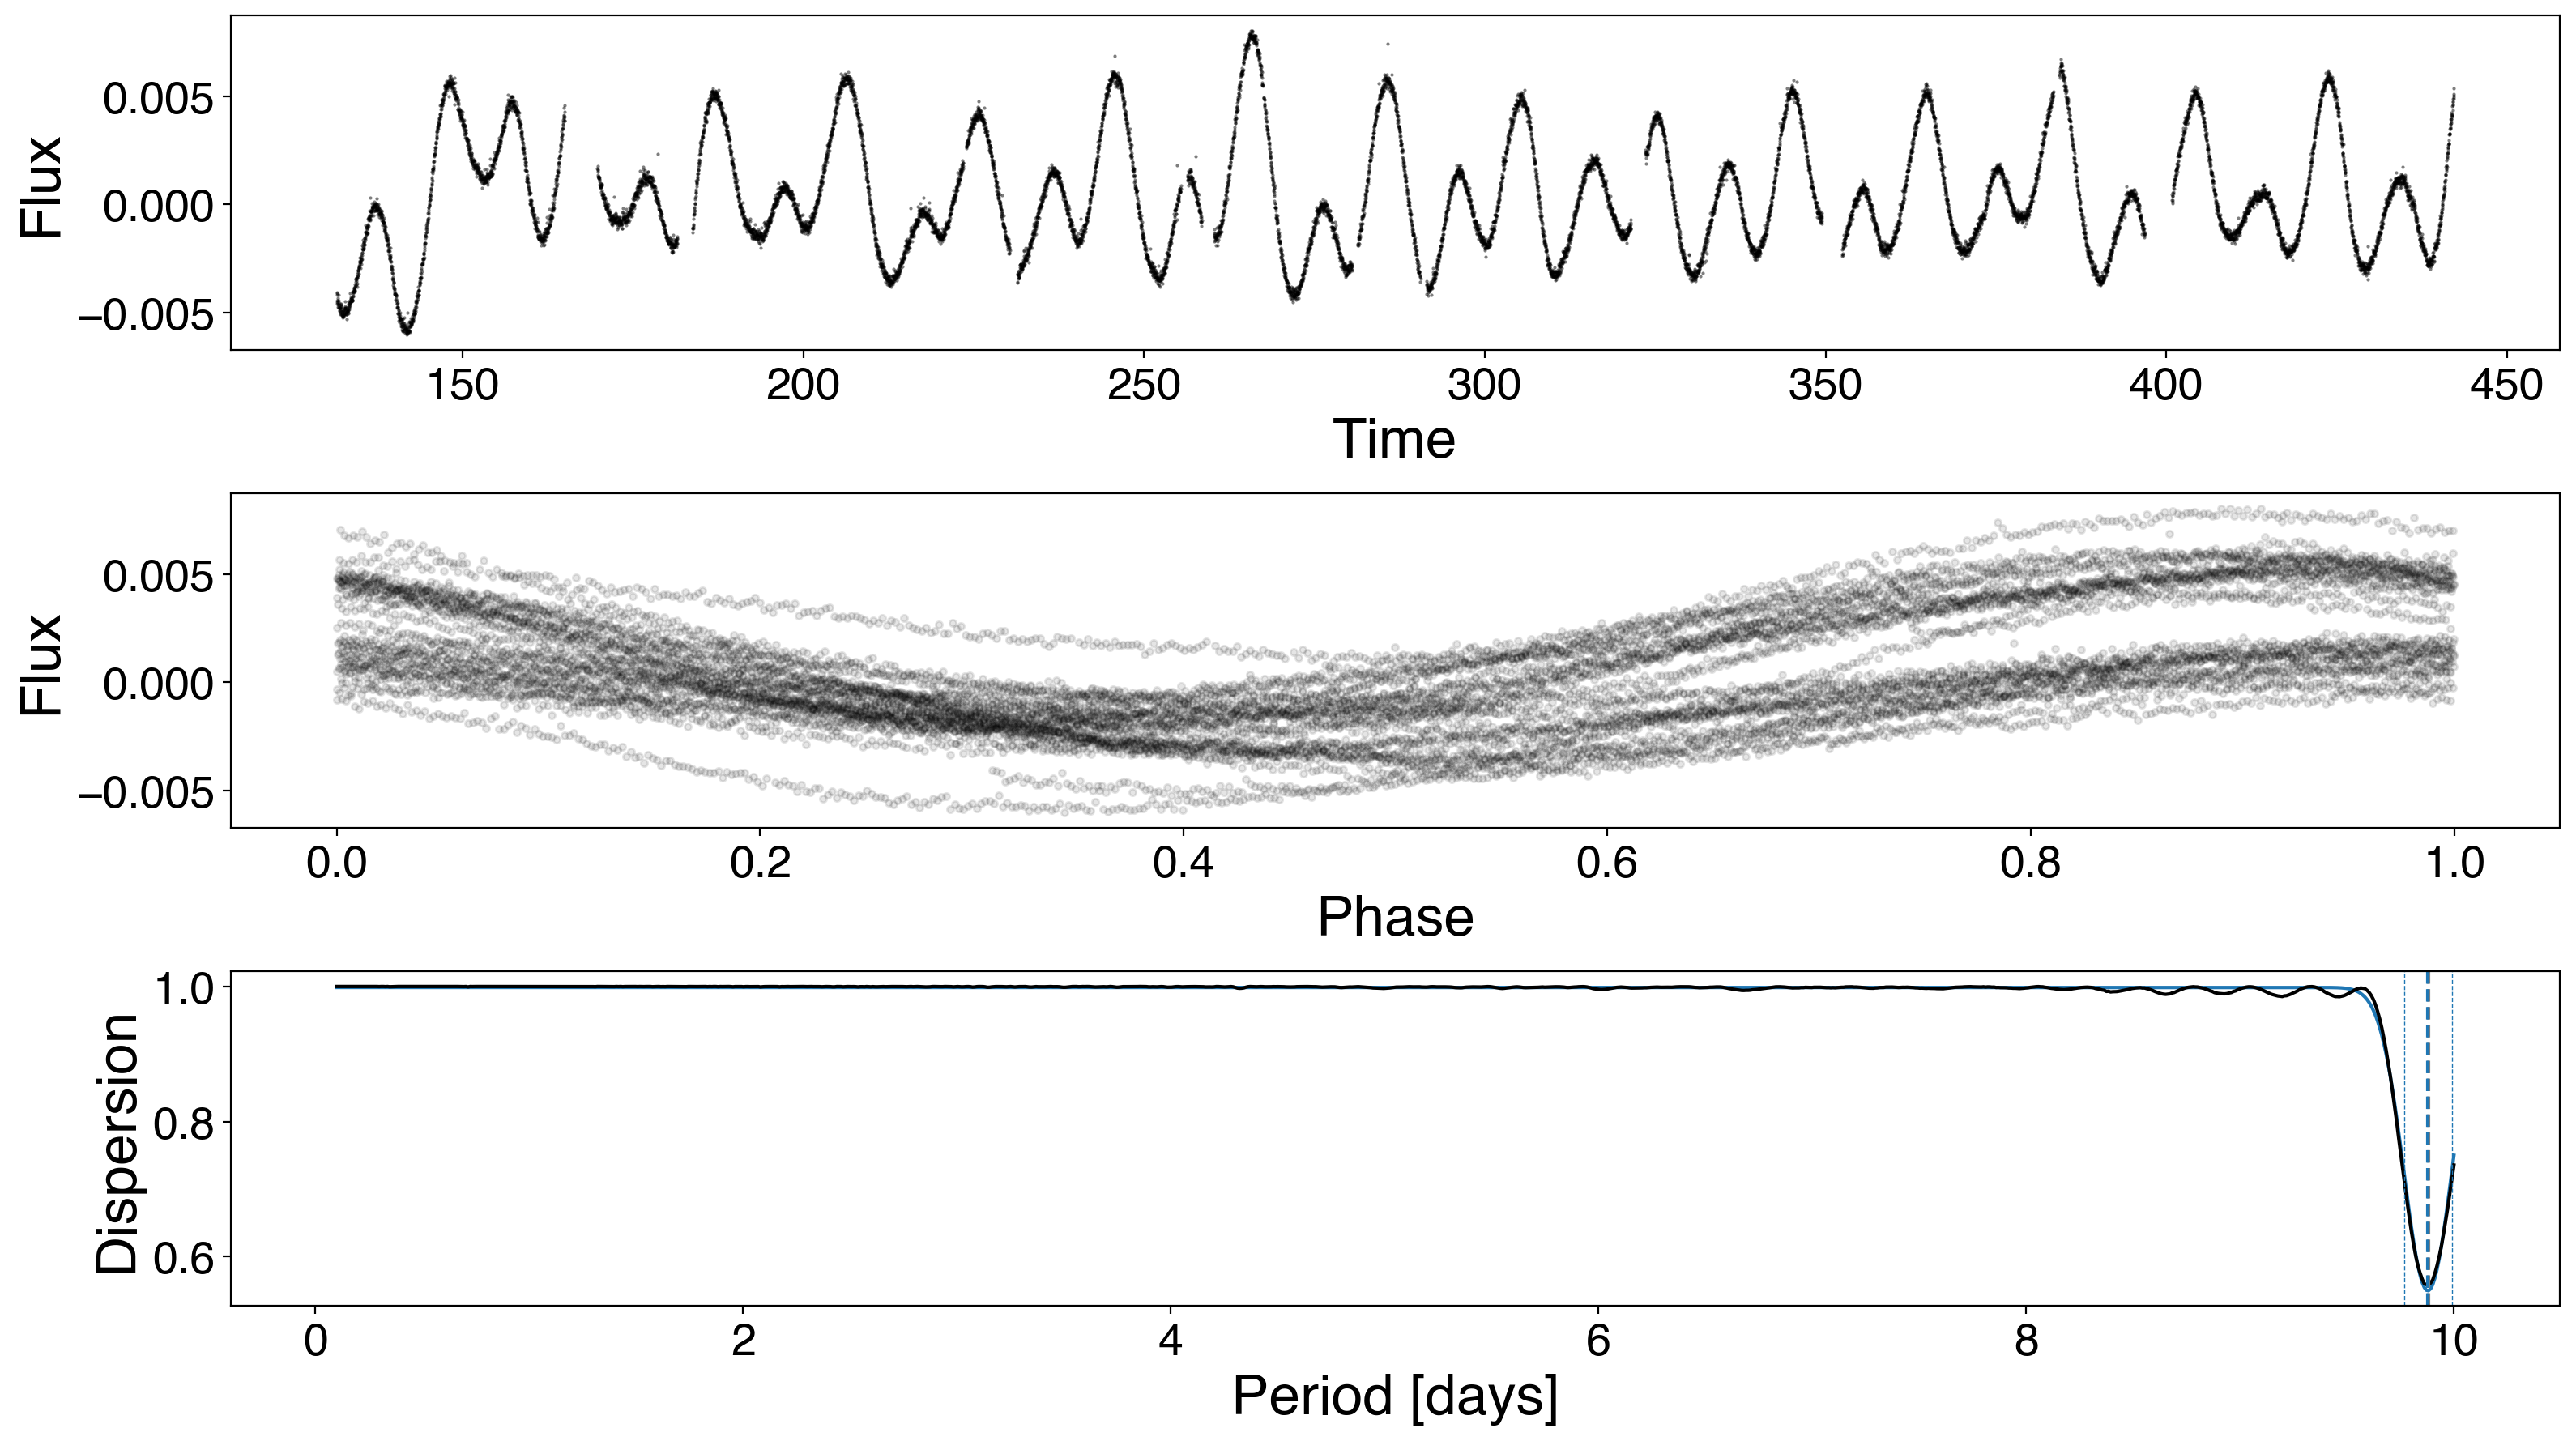

In [29]:
rotate_fig5.pdm_plot();

# TESS Lightcurves for 5a

In [30]:
search_result = lk.search_targetpixelfile(target = "19:20:31.812+40:05:30.23", mission='TESS')

In [31]:
tpf = search_result.download(quality_bitmask='default')

/Users/ilanadoran/opt/anaconda3/lib/python3.7/site-packages/lightkurve/search.py:225: LightkurveWarning: Cannot download from an empty search result.
  LightkurveWarning)


In [32]:
search_result_ID = lk.search_targetpixelfile(target = "4918333", mission='TESS')

In [33]:
tpf_ID = search_result_ID.download(quality_bitmask='default')

/Users/ilanadoran/opt/anaconda3/lib/python3.7/site-packages/lightkurve/search.py:225: LightkurveWarning: Cannot download from an empty search result.
  LightkurveWarning)


# Kepler Lightcurves for 5b

In [34]:
print('The McQuillan ACF is : ', m_dwarf_rotation_period[4][KIDs.index('9201463')])

The McQuillan ACF is :  5.507


In [35]:
five_b = search_lightcurvefile(figure_5b, quarter = 1).download()

In [36]:
five_b_SAP = five_b.SAP_FLUX
five_b_PDC = five_b.PDCSAP_FLUX

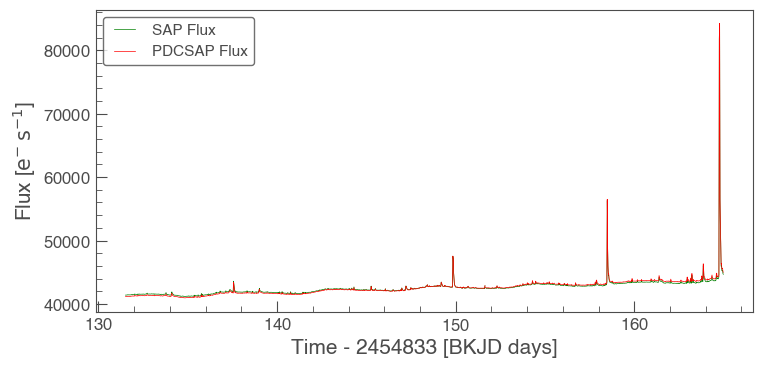

In [37]:
ax1 = five_b_SAP.plot(label='SAP Flux', color = 'green');
five_b_PDC.plot(label='PDCSAP Flux', color = 'red', ax=ax1);

In [38]:
figure_five_b = combining_quarters('9201463')
flux_5b = figure_five_b[0]
time_5b = figure_five_b[1]
flux_error_5b = figure_five_b[2]

Text(0, 0.5, 'Normalized Flux')

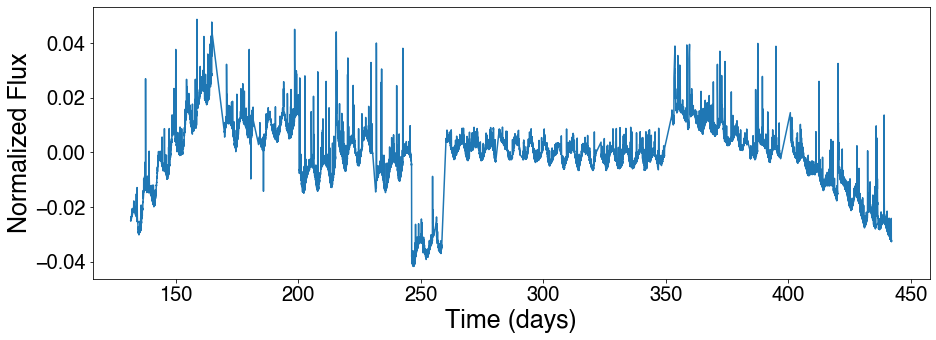

In [39]:
plt.figure(figsize=(15,5))
plt.plot(time_5b, flux_5b)
plt.xlabel('Time (days)')
plt.ylabel('Normalized Flux')

In [40]:
figure_five_b_PDC = combining_PDC_quarters('9201463')
flux_5b_PDC = figure_five_b_PDC[0]
time_5b_PDC = figure_five_b_PDC[1]
flux_error_5b_PDC = figure_five_b_PDC[2]

Text(0, 0.5, 'Normalized Flux')

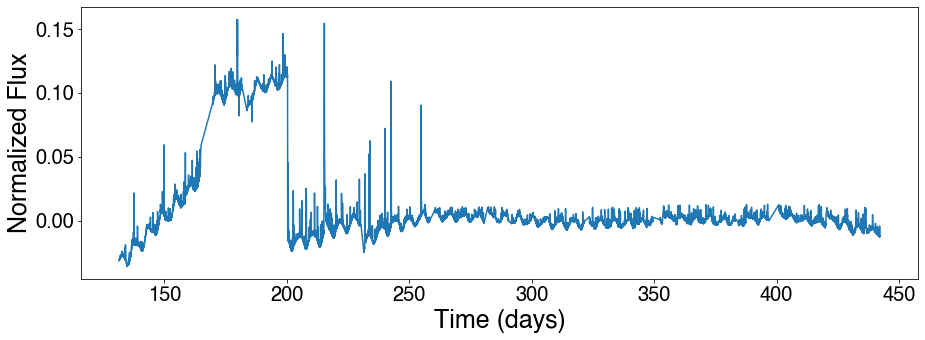

In [41]:
plt.figure(figsize=(15,5))
plt.plot(time_5b_PDC, flux_5b_PDC)
plt.xlabel('Time (days)')
plt.ylabel('Normalized Flux')

In [42]:
acf_fig5b = ac_mq_Q1_Q4_PDC('9201463', 1000);

Text(0.5, 1.0, 'Autocorrelated Figure 5b')

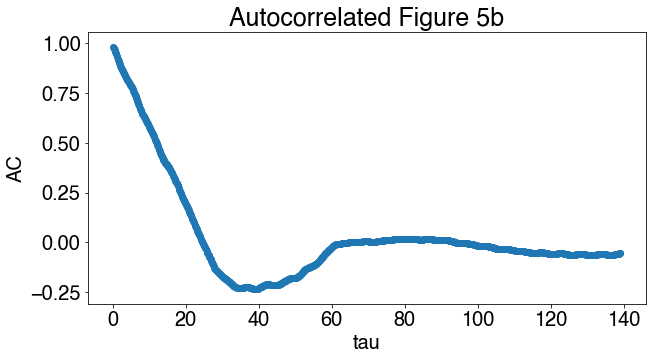

In [43]:
plt.figure(figsize=(10,5))
plt.scatter(acf_fig5b[1], acf_fig5b[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated Figure 5b', fontsize = 25)

In [44]:
rotate_fig5b = ss.RotationModel(time_5b_PDC, flux_5b_PDC, flux_error_5b_PDC)

22.76937579408992


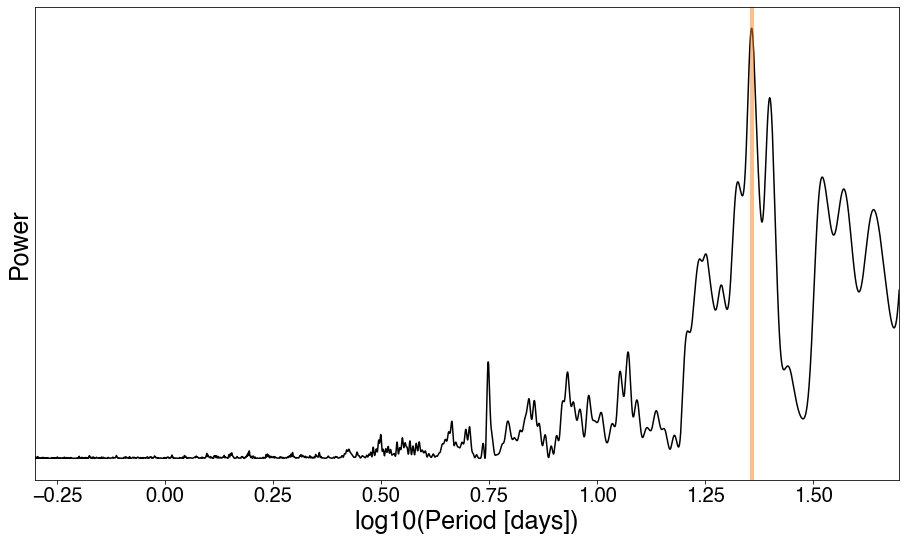

In [45]:
ls_period_5b = rotate_fig5b.ls_rotation()
print(ls_period_5b)
rotate_fig5b.ls_plot();

In [46]:
period_grid = np.linspace(.1, 10, 1000)
pdm_period, period_err = rotate_fig5b.pdm_rotation(period_grid, pdm_nbins=10)
print(pdm_period, period_err)

100%|██████████| 1000/1000 [00:20<00:00, 48.85it/s]

5.59009009009009 0.5503228436579561


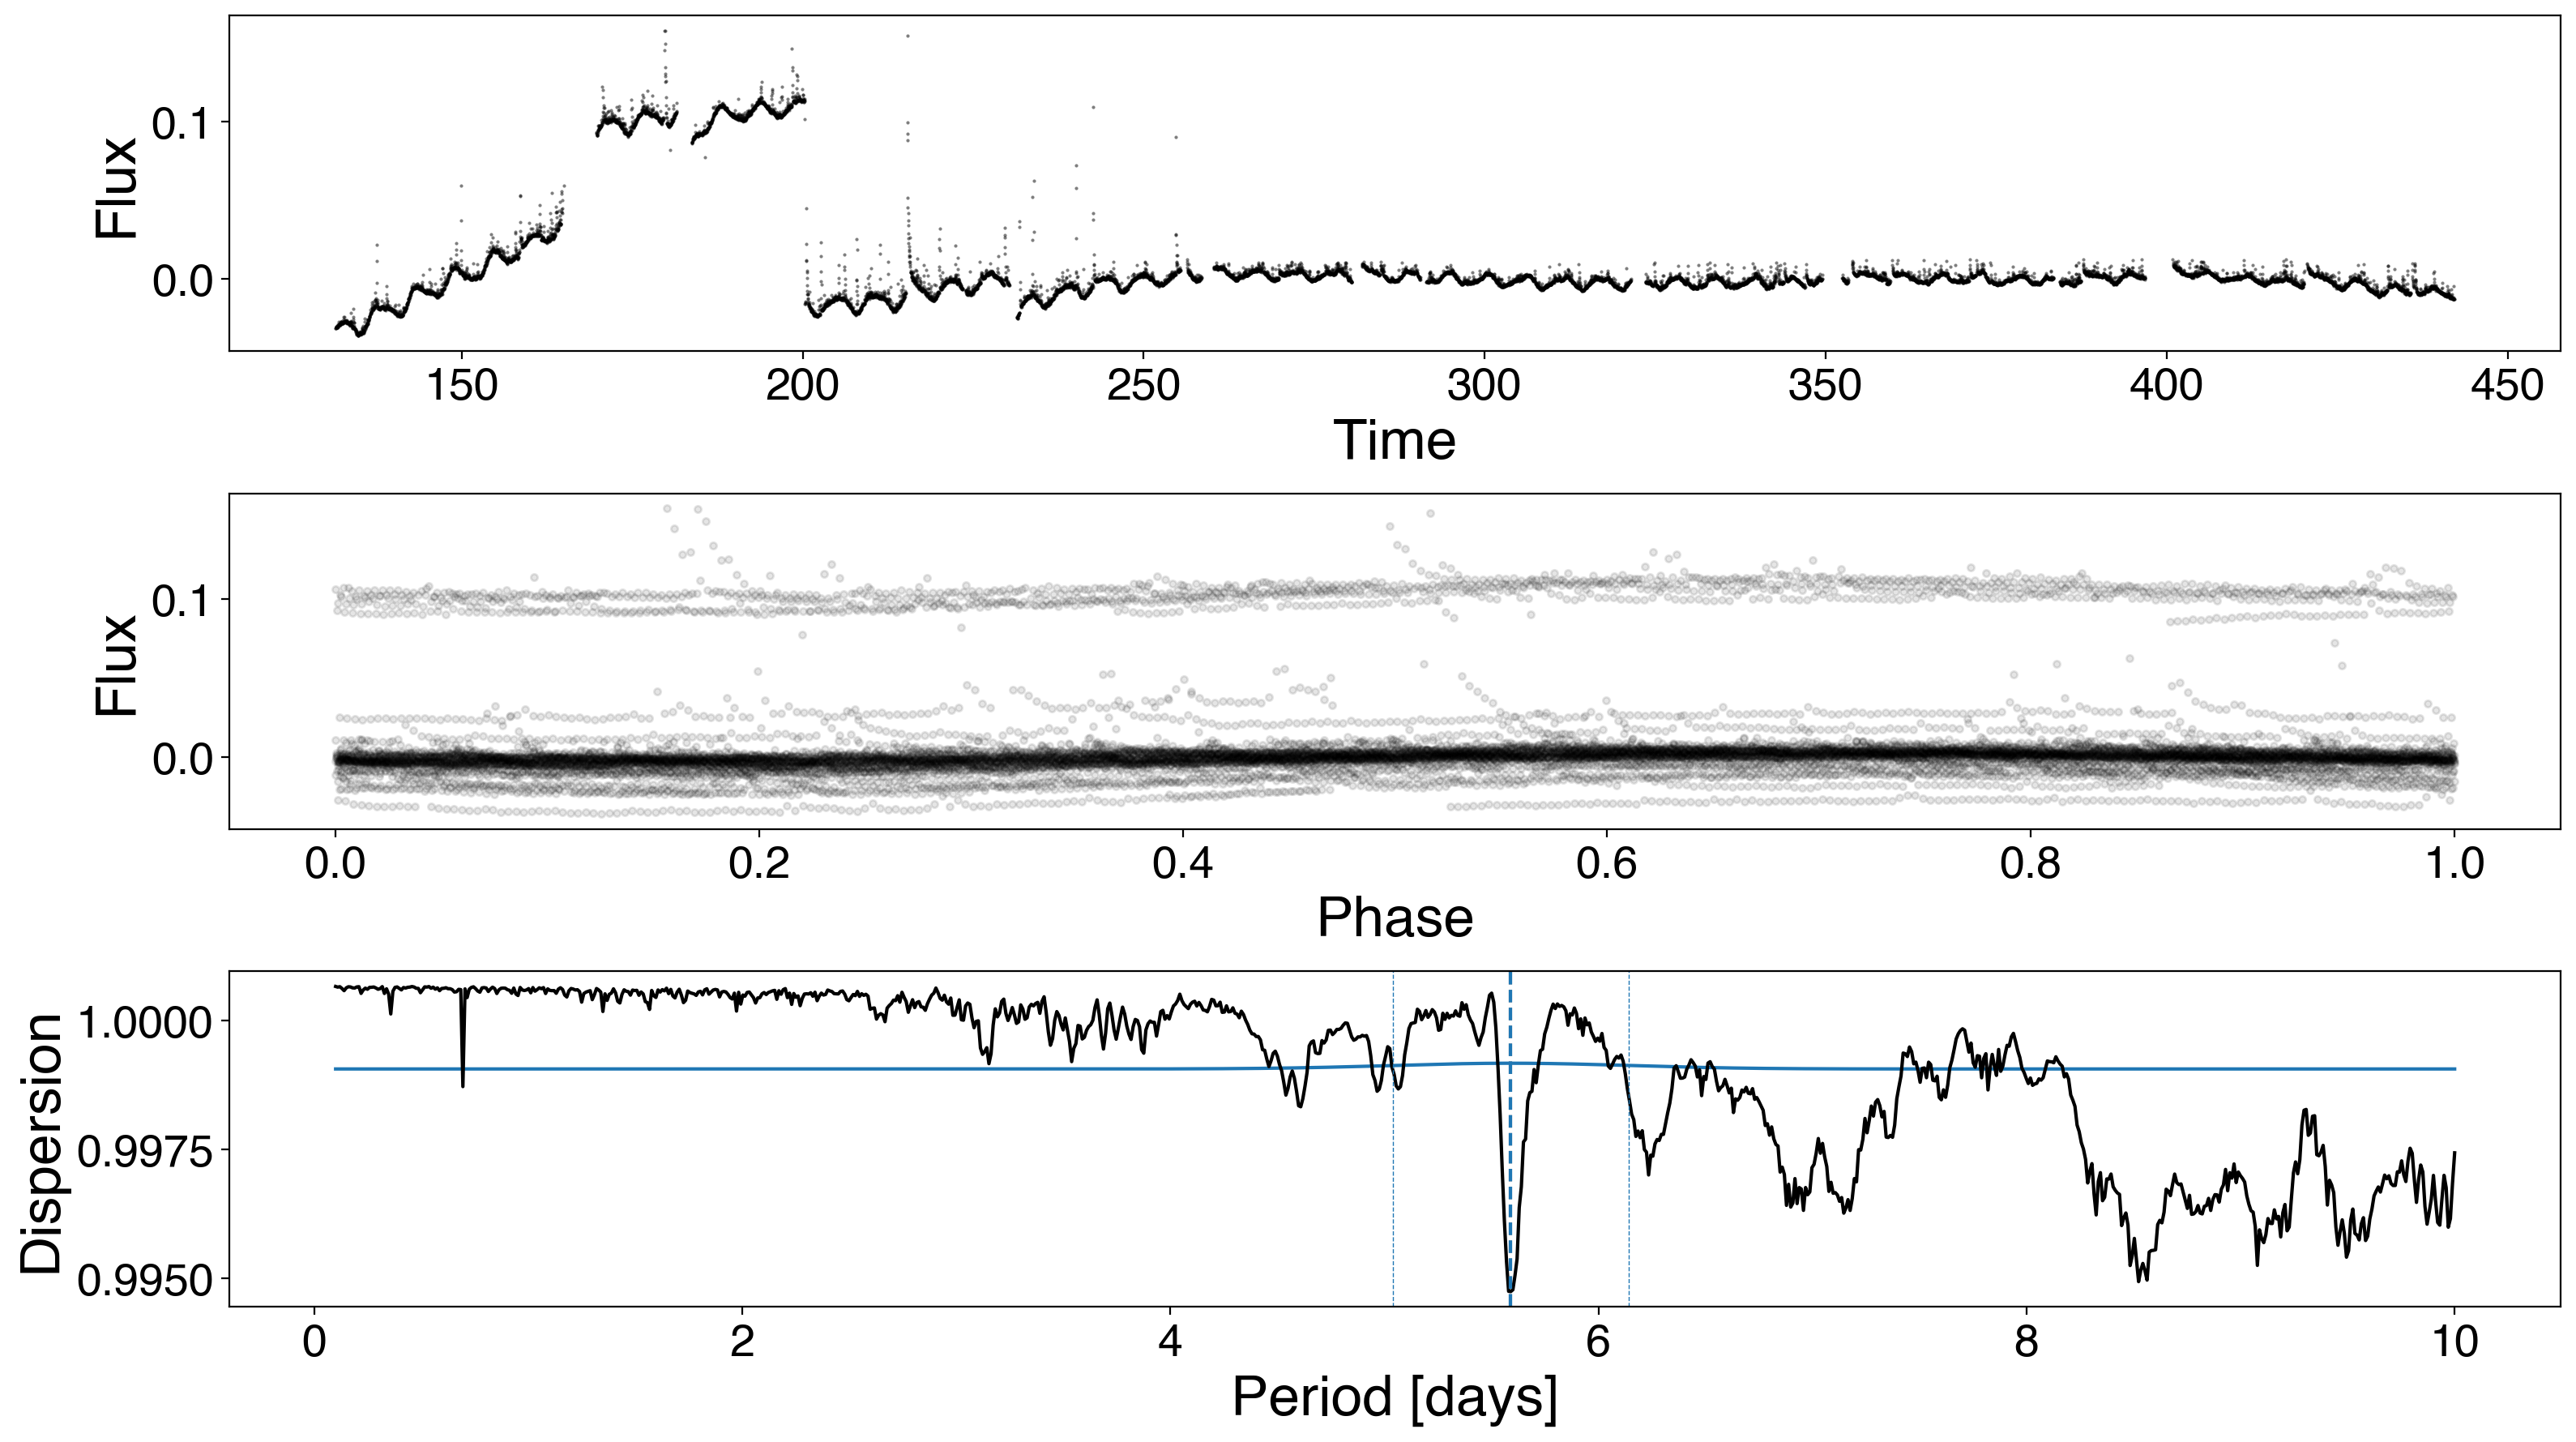

In [47]:
rotate_fig5b.pdm_plot();

# TESS Lightcurves for 5b

In [48]:
search_tess_5b = lk.search_targetpixelfile(target = "18:52:33.818+45:38:33.99", mission='TESS')

In [49]:
tess_5b = search_tess_5b.download_all(quality_bitmask='default')
print(tess_5b[0].targetid)

164458193


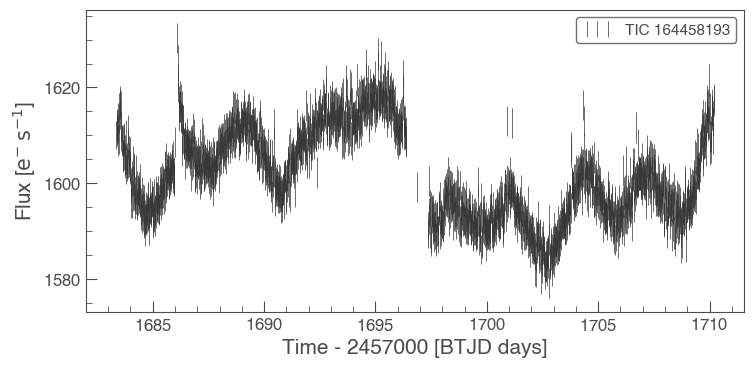

In [50]:
tess_5b_tpf1 = tess_5b[0].to_lightcurve(aperture_mask=tess_5b[0].pipeline_mask).remove_outliers(sigma=3).bin(binsize=10)
tess_5b_tpf1.errorbar()

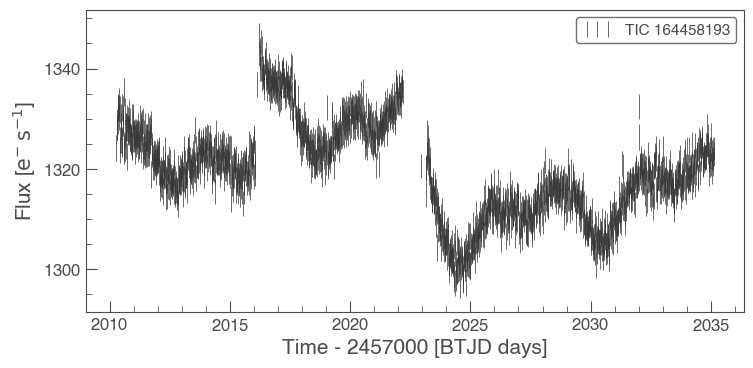

In [51]:
tess_5b_tpf2 = tess_5b[1].to_lightcurve(aperture_mask=tess_5b[1].pipeline_mask).remove_outliers(sigma=3).bin(binsize=10)
tess_5b_tpf2.errorbar()

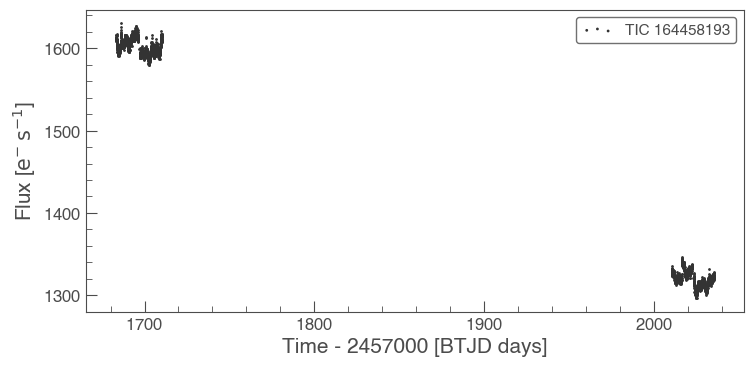

In [52]:
stitched_lc = tess_5b_tpf1.append(tess_5b_tpf2)
stitched_lc.scatter();

In [53]:
tess_figure_five_b = combining_tess_quarters("18:52:33.818+45:38:33.99")
tess_flux_5b = tess_figure_five_b[0]
tess_time_5b = tess_figure_five_b[1]
tess_flux_error_5b = tess_figure_five_b[2]

Text(0, 0.5, 'Normalized Flux')

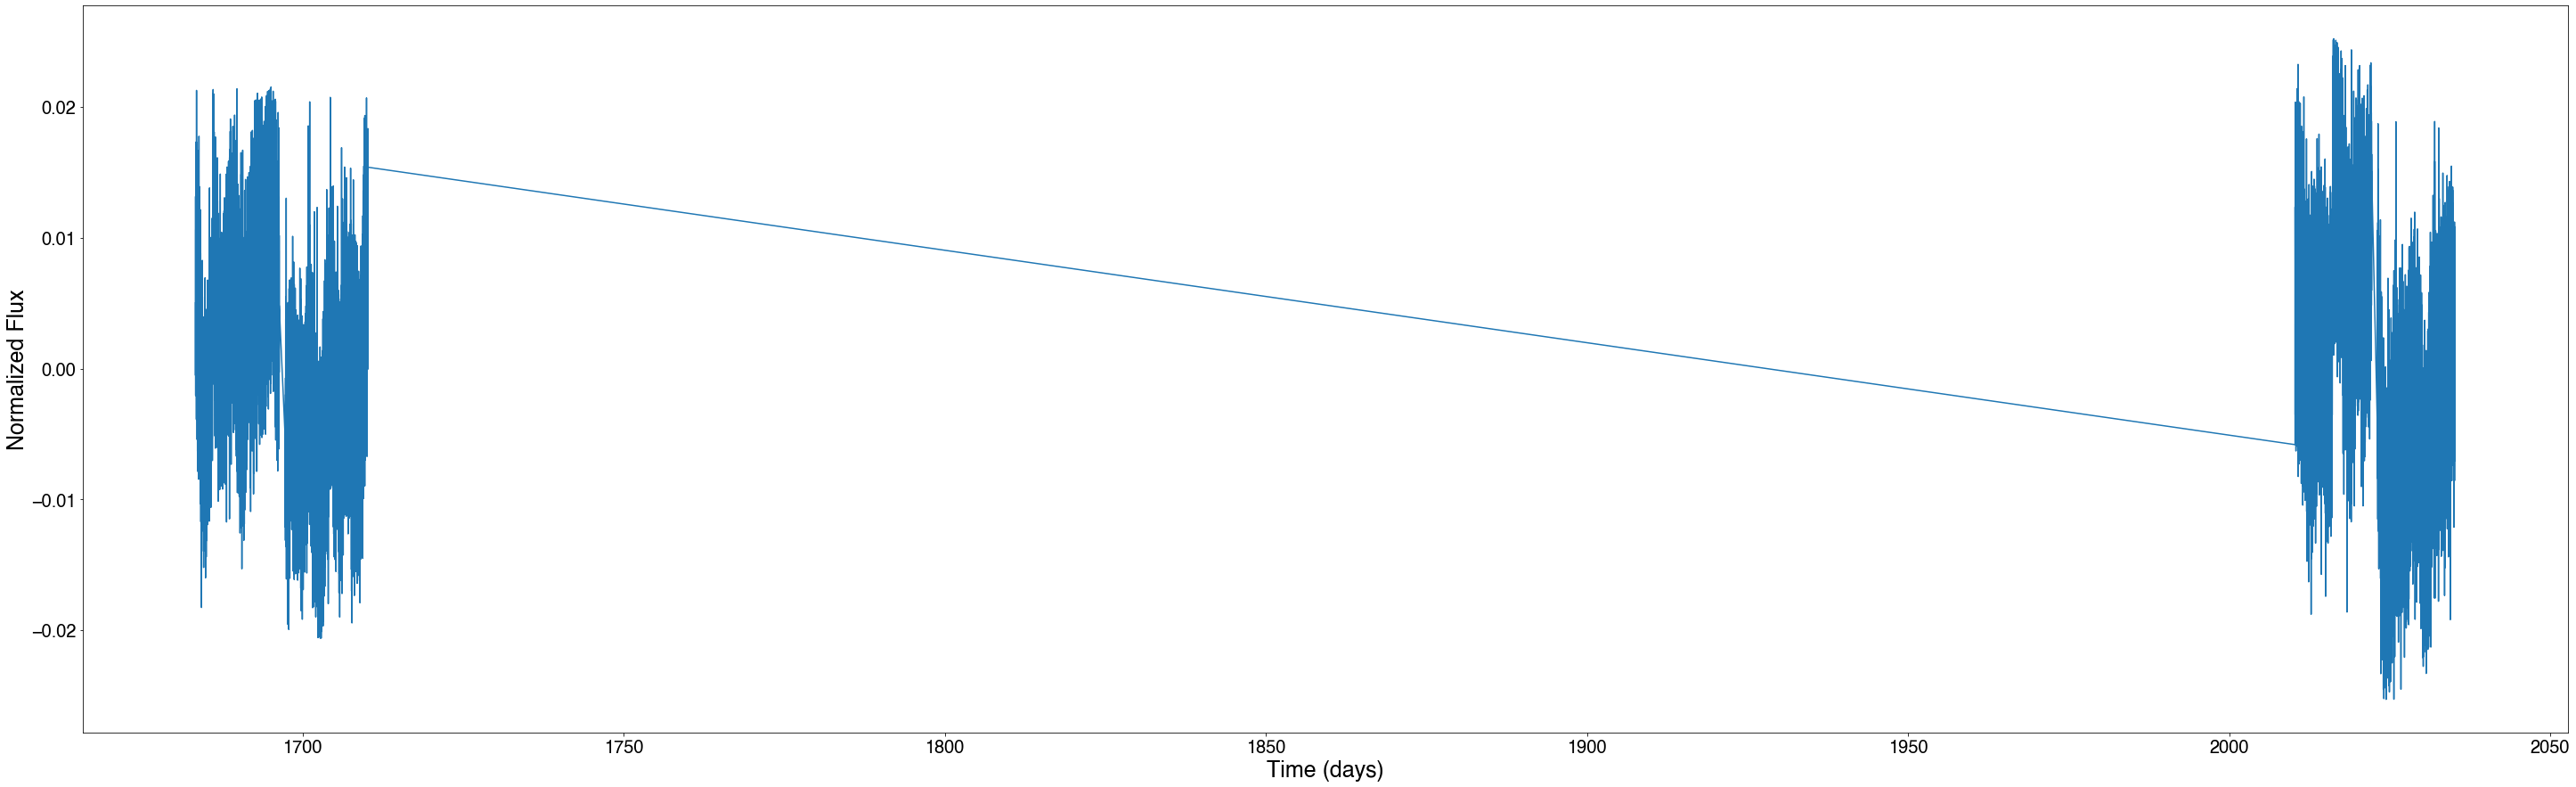

In [54]:
plt.figure(figsize=(50,15))
plt.plot(tess_time_5b, tess_flux_5b)
plt.xlabel('Time (days)')
plt.ylabel('Normalized Flux')

In [55]:
acf_tess_5c = ac_mq_tess("18:52:33.818+45:38:33.99", 1000);

Text(0.5, 1.0, 'TESS Autocorrelated Figure 5c')

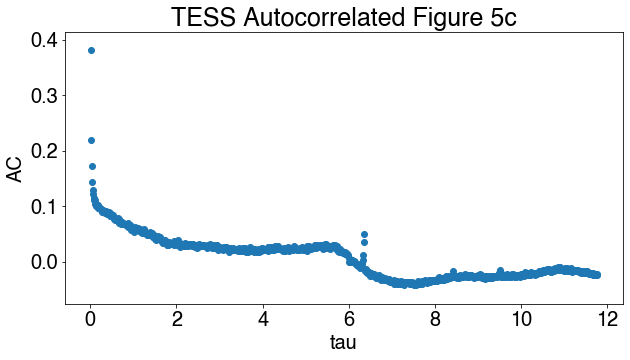

In [56]:
plt.figure(figsize=(10,5))
plt.scatter(acf_tess_5c[1], acf_tess_5c[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('TESS Autocorrelated Figure 5c', fontsize = 25)

In [57]:
rotate_tess_5b = ss.RotationModel(tess_time_5b, tess_flux_5b, tess_flux_error_5b)

23.230190257160775


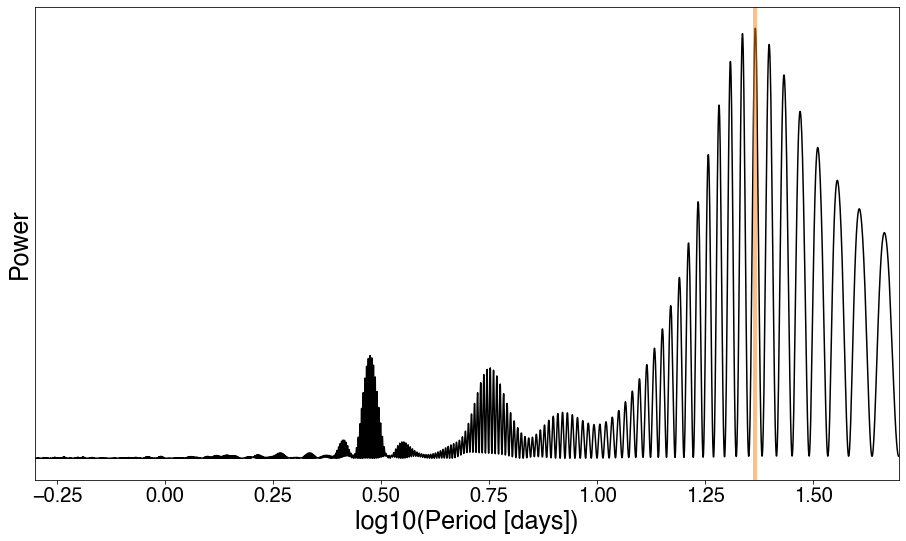

In [58]:
tess_period_5b = rotate_tess_5b.ls_rotation()
print(tess_period_5b)
rotate_tess_5b.ls_plot();

In [59]:
period_grid_tess5b = np.linspace(.1, 10, 1000)
pdm_period_tess5b, period_err_tess5b = rotate_tess_5b.pdm_rotation(period_grid_tess5b, pdm_nbins=10)
print(pdm_period_tess5b, period_err_tess5b)

100%|██████████| 1000/1000 [01:09<00:00, 14.31it/s]

5.956756756756757 0.3295158607251207


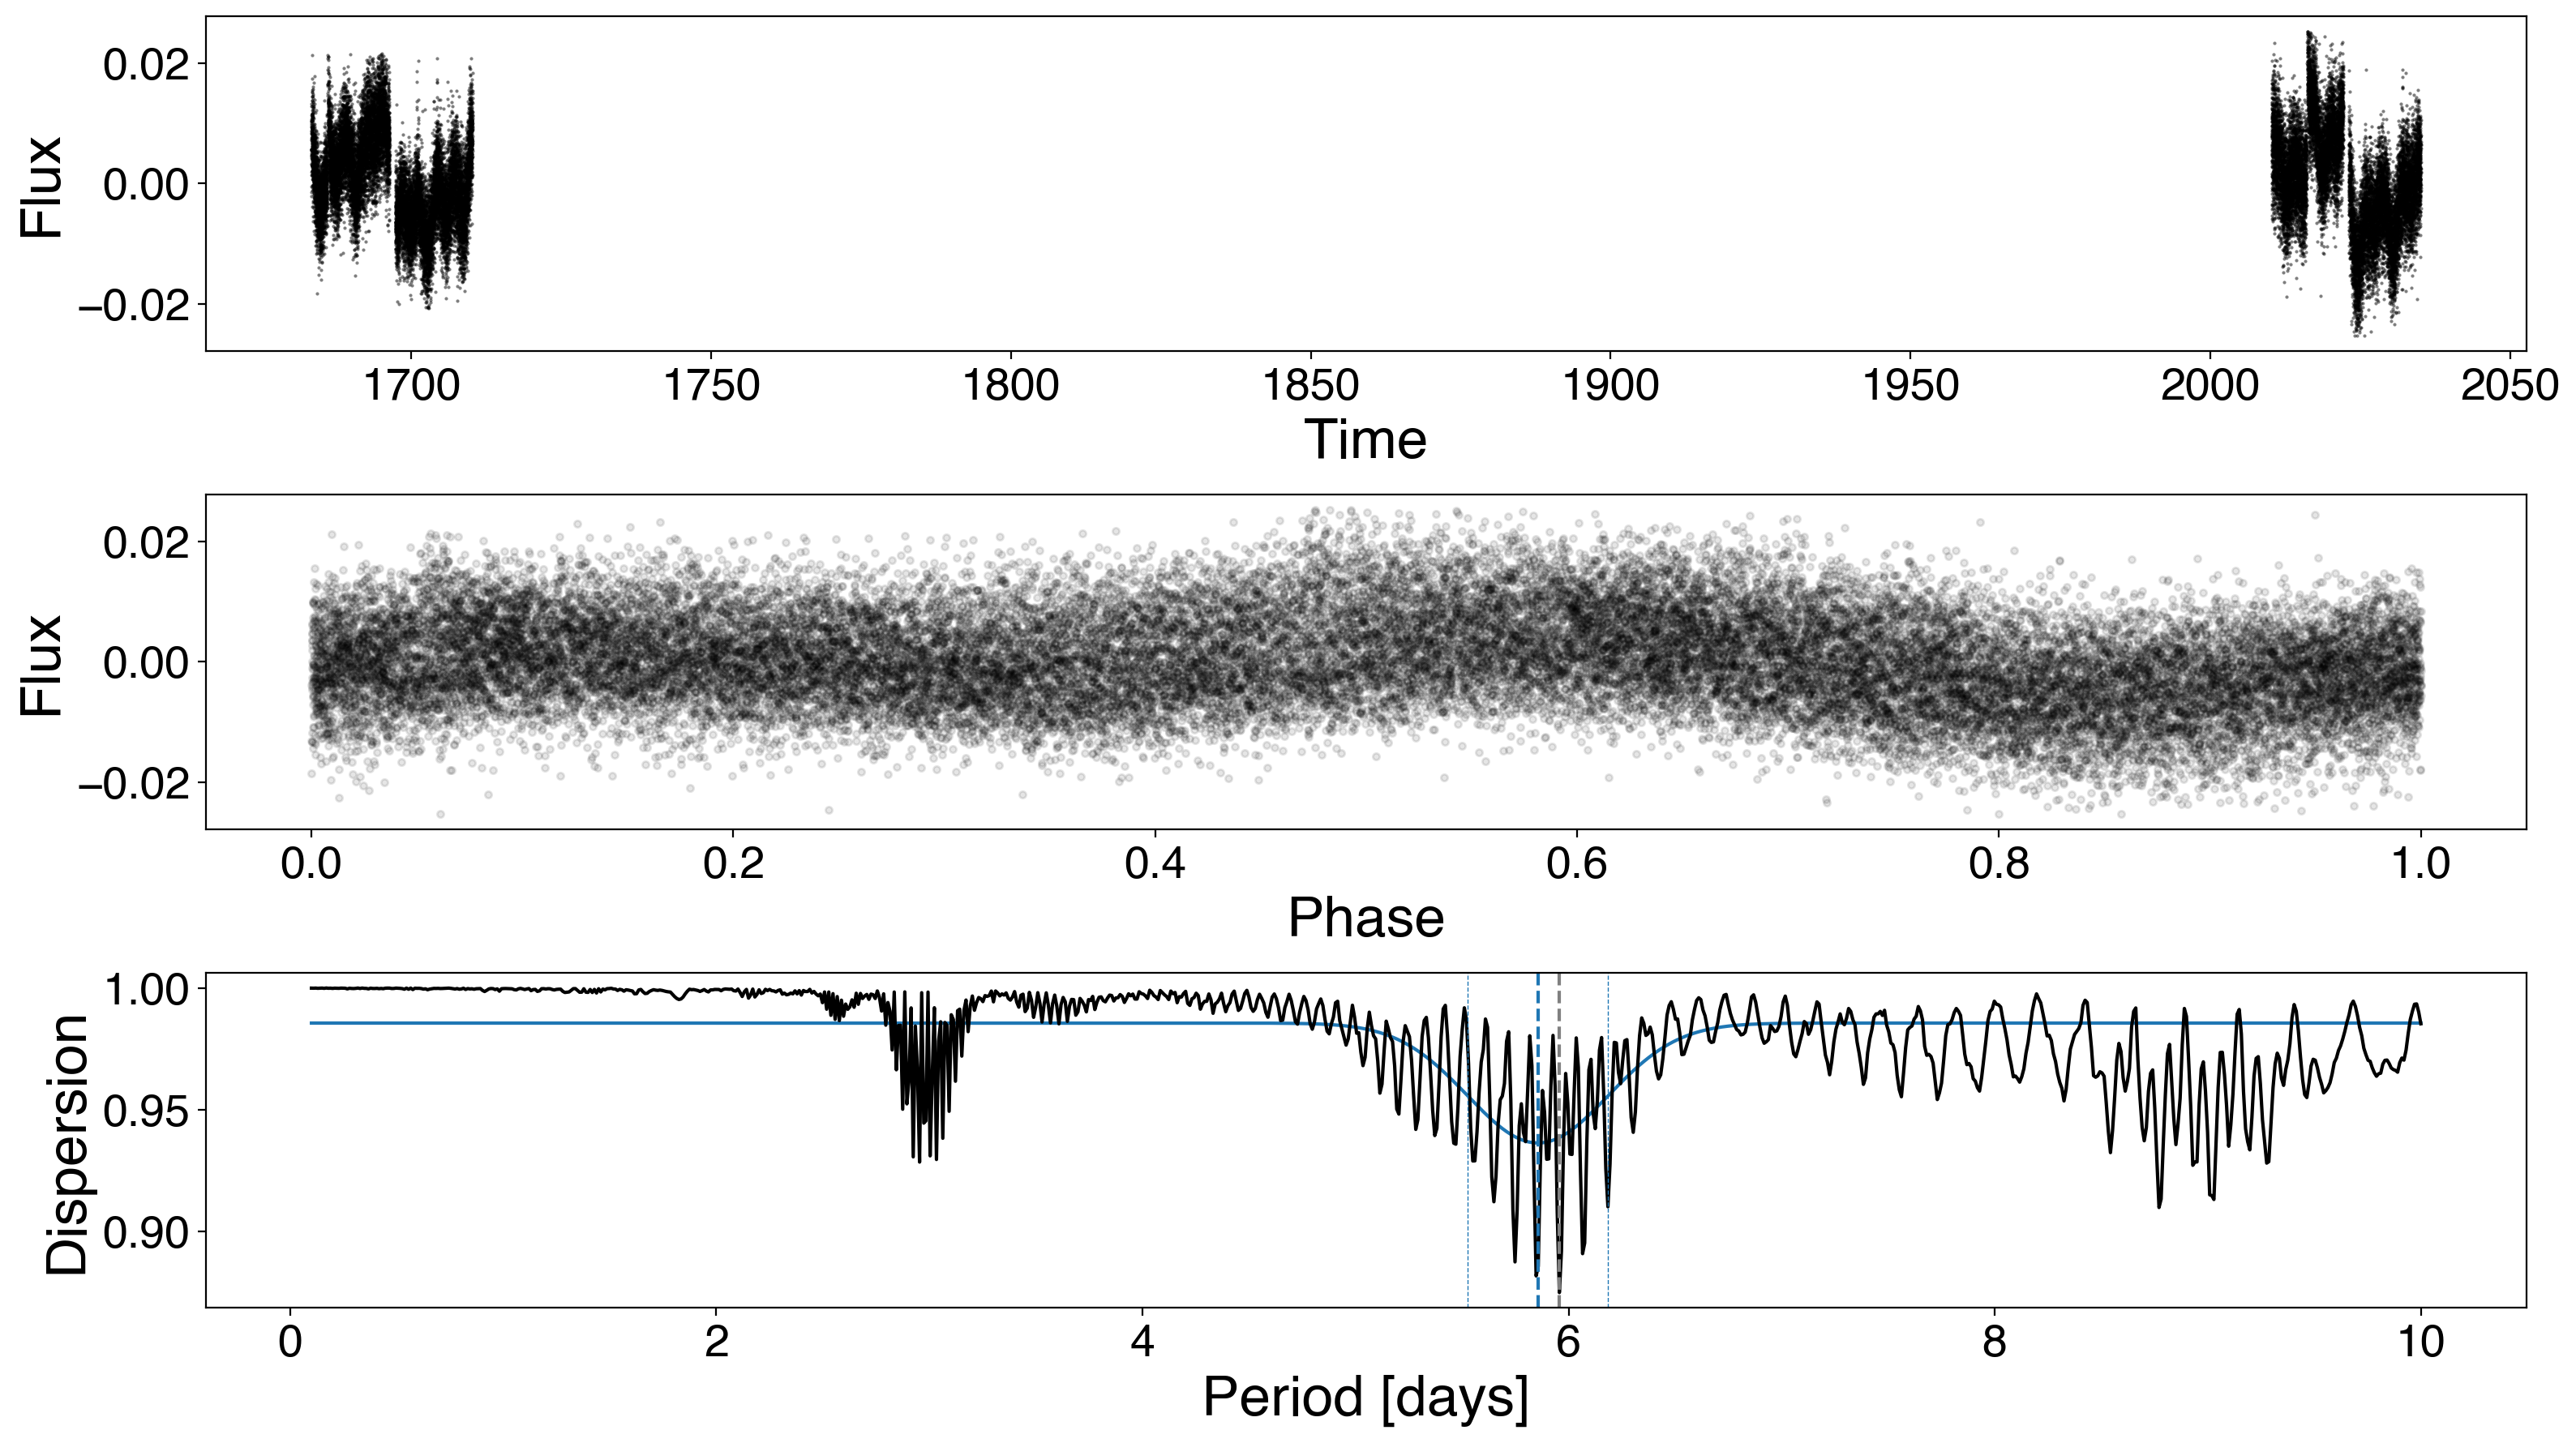

In [60]:
rotate_tess_5b.pdm_plot();

# Kepler Lightcurves for 5c 

In [61]:
print('The McQuillan ACF is : ', m_dwarf_rotation_period[4][KIDs.index('9488191')])

The McQuillan ACF is :  15.938


In [62]:
five_c = search_lightcurvefile(figure_5c, quarter = 1).download()

In [63]:
five_c_SAP = five_c.SAP_FLUX
five_c_PDC = five_c.PDCSAP_FLUX

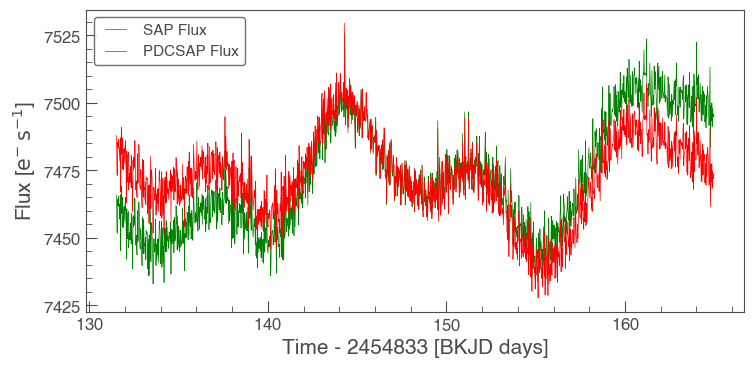

In [64]:
ax2 = five_c_SAP.plot(label='SAP Flux', color = 'green');
five_c_PDC.plot(label='PDCSAP Flux', color = 'red', ax=ax2);

In [65]:
figure_five_c = combining_quarters('9488191')
flux_5c = figure_five_c[0]
time_5c = figure_five_c[1]
flux_error_5c = figure_five_c[2]

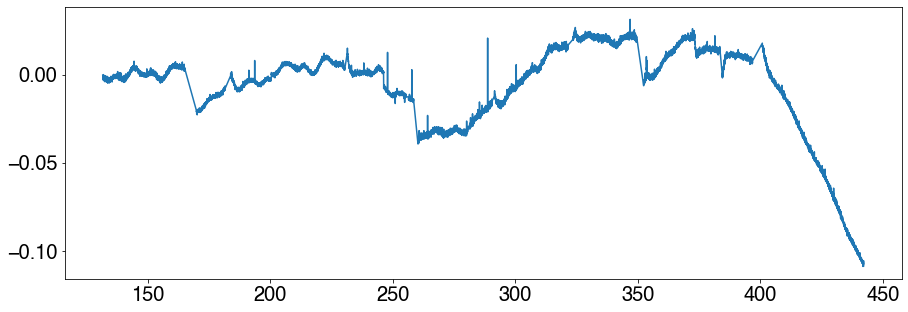

In [66]:
plt.figure(figsize=(15,5))
plt.plot(time_5c, flux_5c)

In [67]:
figure_five_c_PDC = combining_PDC_quarters('9488191')
flux_5c_PDC = figure_five_c_PDC[0]
time_5c_PDC = figure_five_c_PDC[1]
flux_error_5c_PDC = figure_five_c_PDC[2]

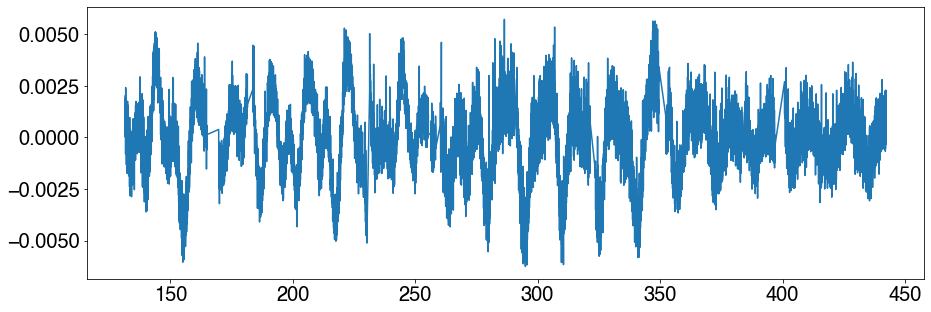

In [68]:
plt.figure(figsize=(15,5))
plt.plot(time_5c_PDC, flux_5c_PDC)

In [69]:
acf_fig5c = ac_mq_Q1_Q4_PDC('9488191', 1000);

Text(0.5, 1.0, 'Autocorrelated Figure 5c')

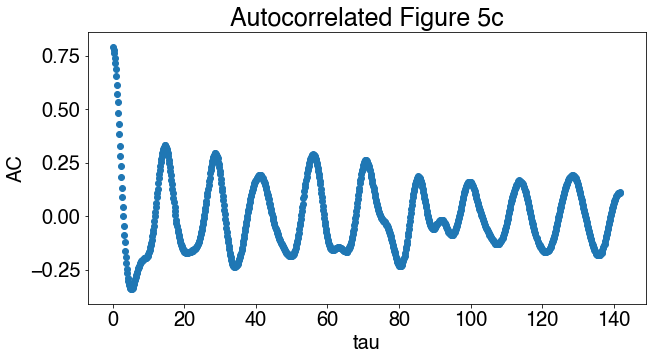

In [70]:
plt.figure(figsize=(10,5))
plt.scatter(acf_fig5c[1], acf_fig5c[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated Figure 5c', fontsize = 25)

In [71]:
rotate_fig5c = ss.RotationModel(time_5c_PDC, flux_5c_PDC, flux_error_5c_PDC)

15.621133730738949


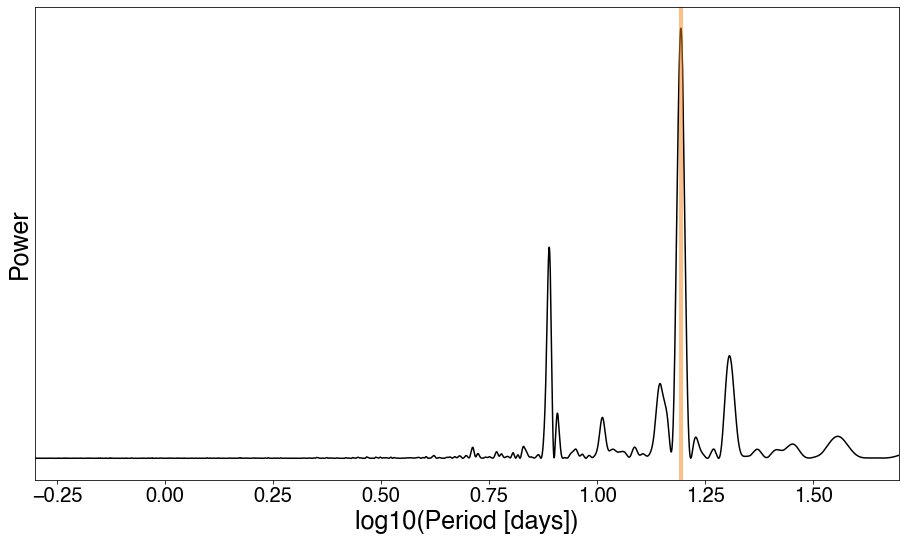

In [72]:
ls_period_5c = rotate_fig5c.ls_rotation()
print(ls_period_5c)
rotate_fig5c.ls_plot();

In [73]:
period_grid_5c = np.linspace(.1, 10, 1000)
pdm_period_5c, period_err_5c = rotate_fig5c.pdm_rotation(period_grid_5c, pdm_nbins=10)
print(pdm_period_5c, period_err_5c)

100%|██████████| 1000/1000 [00:15<00:00, 65.70it/s]

7.740540540540541 0.0886253070337201


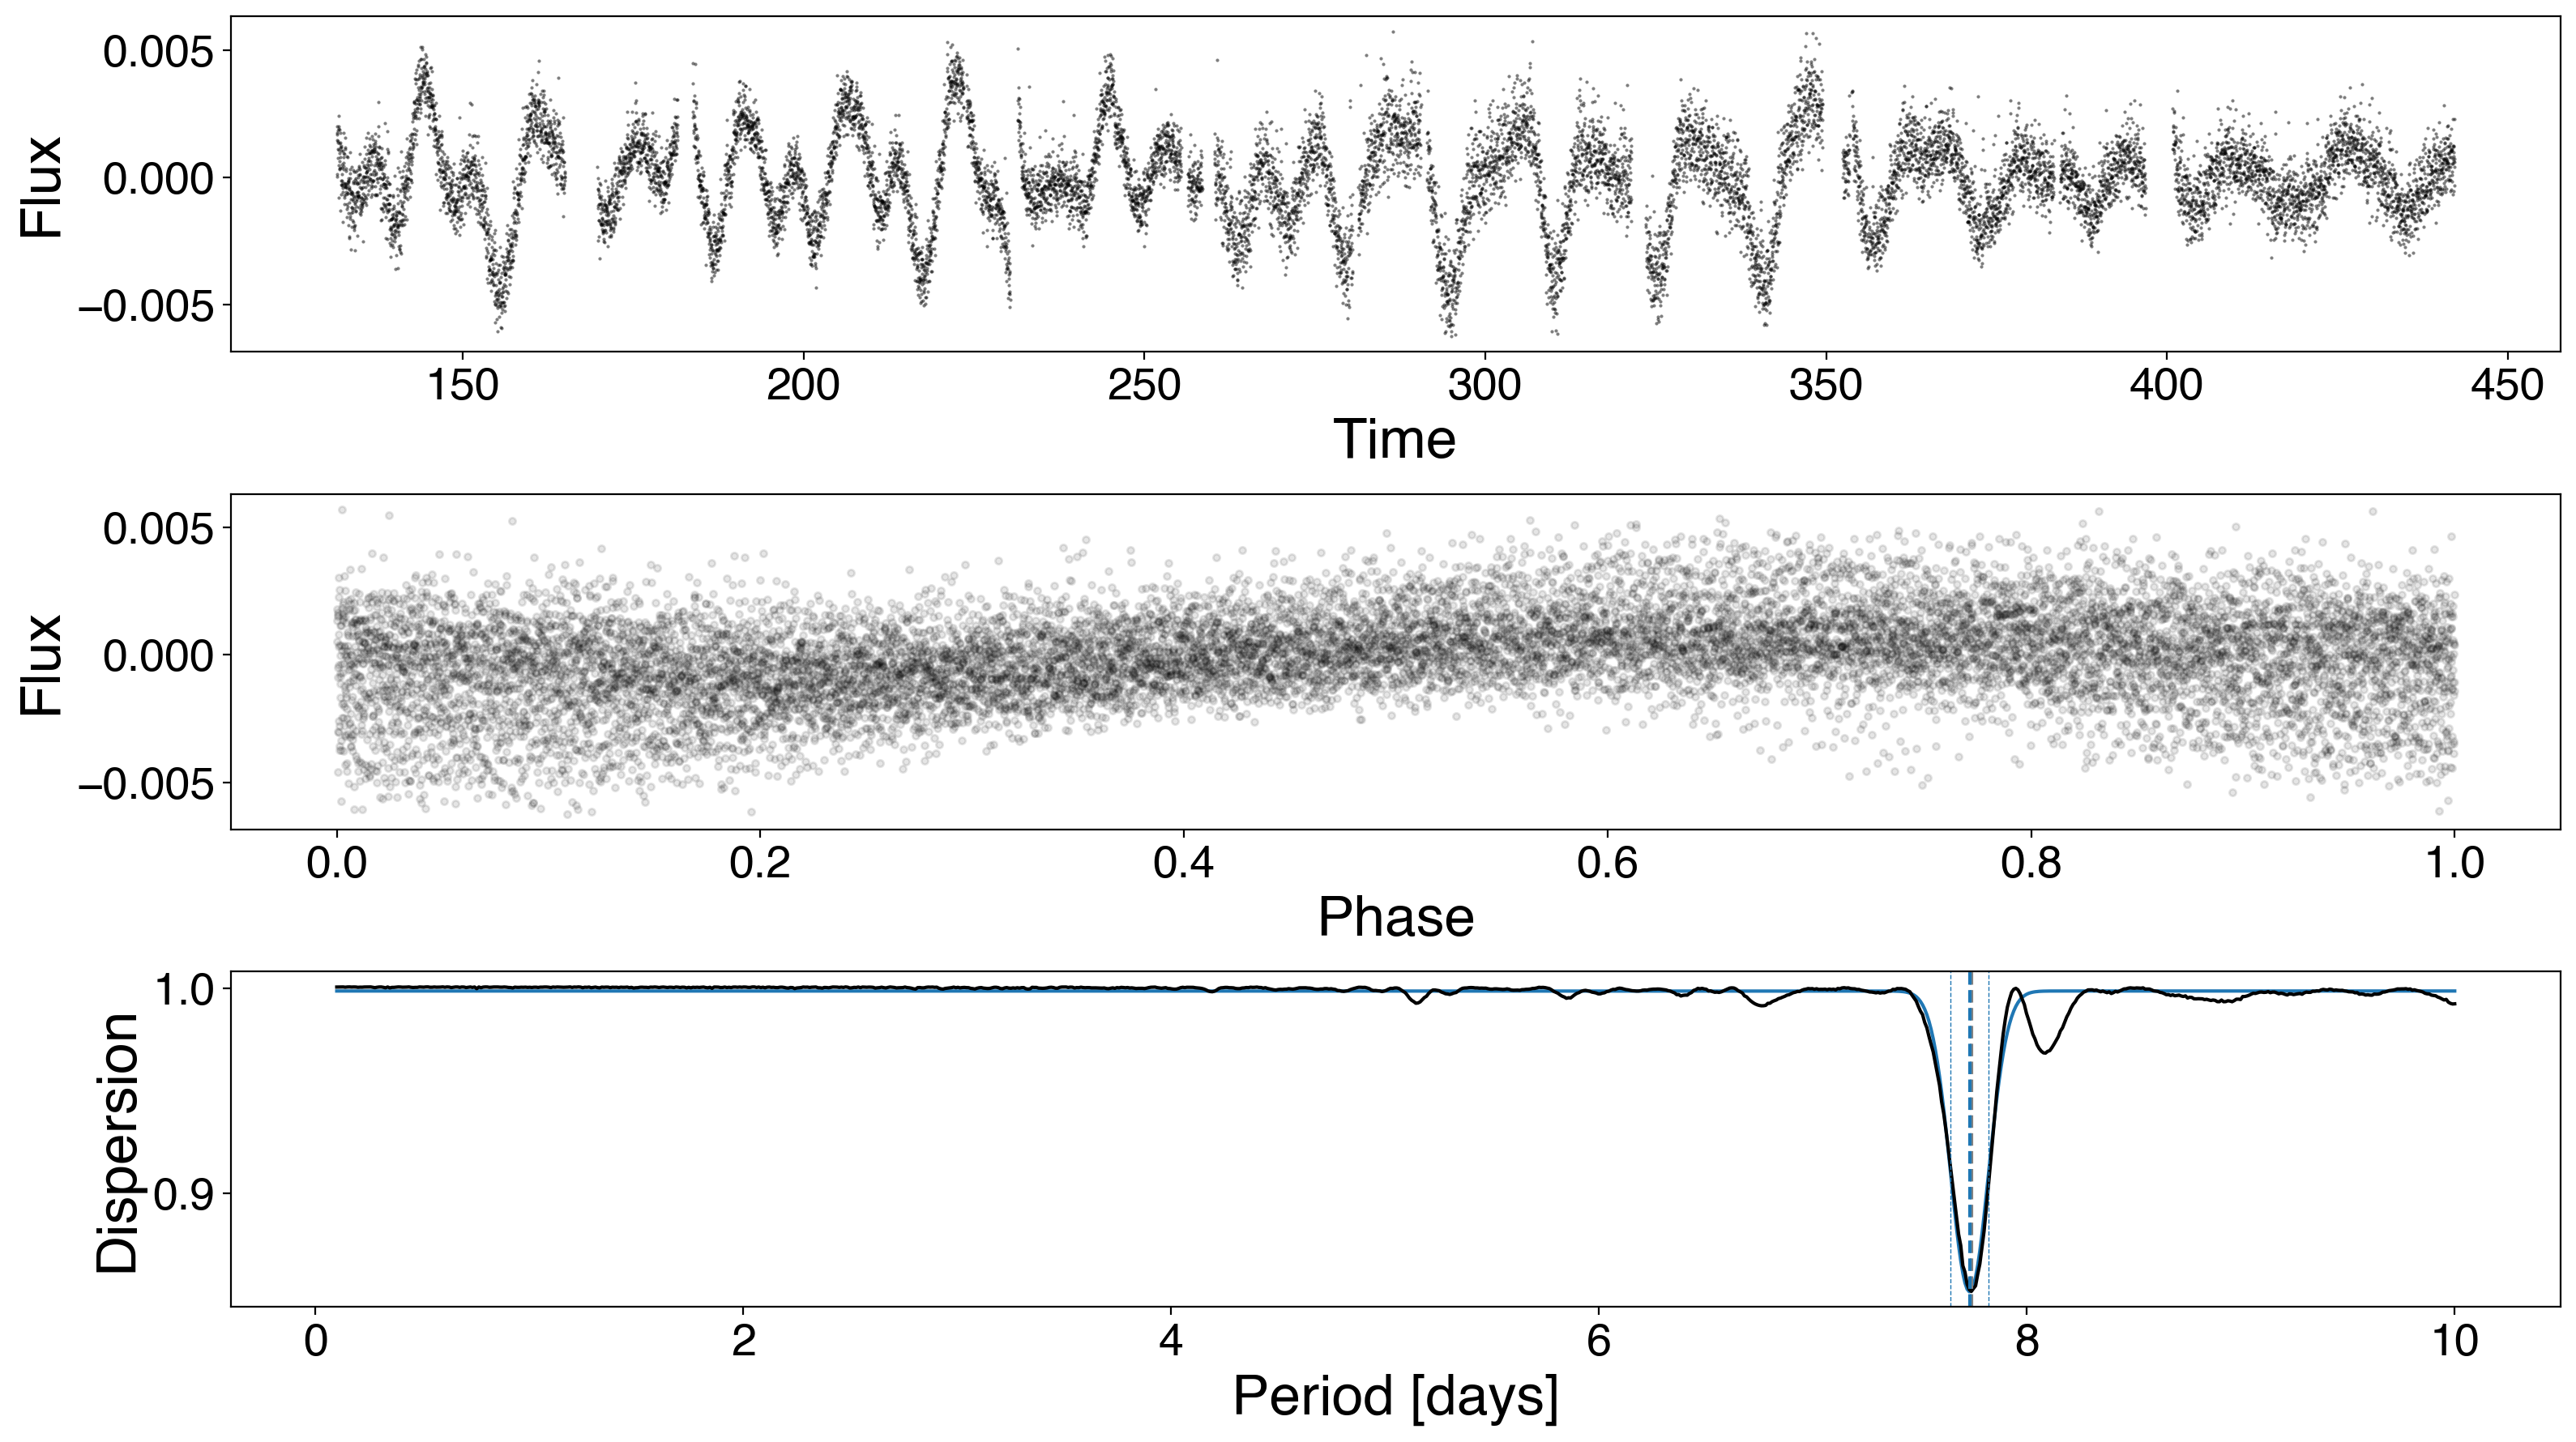

In [74]:
rotate_fig5c.pdm_plot();

# TESS Lightcurves for 5c

In [75]:
search_tess_5c = lk.search_targetpixelfile(target = "19:58:03.190+46:01:01.52", mission='TESS')

In [76]:
tess_5c = search_tess_5c.download_all(quality_bitmask='default')

/Users/ilanadoran/opt/anaconda3/lib/python3.7/site-packages/lightkurve/search.py:284: LightkurveWarning: Cannot download from an empty search result.
  LightkurveWarning)


In [77]:
search_result_IDc = lk.search_targetpixelfile(target = "9488191", mission='TESS')

In [78]:
tpf_IDc = search_result_IDc.download(quality_bitmask='default')

/Users/ilanadoran/opt/anaconda3/lib/python3.7/site-packages/lightkurve/search.py:225: LightkurveWarning: Cannot download from an empty search result.
  LightkurveWarning)


# Kepler Lightcurves for 5d

In [79]:
print('The McQuillan ACF is : ', m_dwarf_rotation_period[4][KIDs.index('7590933')])

The McQuillan ACF is :  27.340


In [80]:
five_d = search_lightcurvefile(figure_5d, quarter = 1).download()

In [81]:
five_d_SAP = five_d.SAP_FLUX
five_d_PDC = five_d.PDCSAP_FLUX

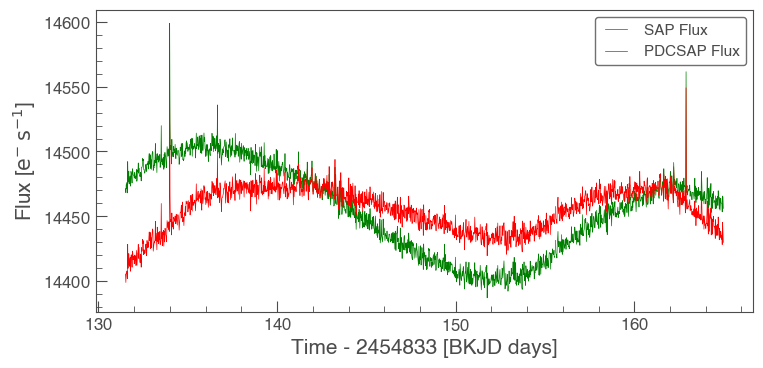

In [82]:
ax3 = five_d_SAP.plot(label='SAP Flux', color = 'green');
five_d_PDC.plot(label='PDCSAP Flux', color = 'red', ax=ax3);

In [83]:
figure_five_d = combining_quarters('7590933')
flux_5d = figure_five_d[0]
time_5d = figure_five_d[1]
flux_error_5d = figure_five_d[2]

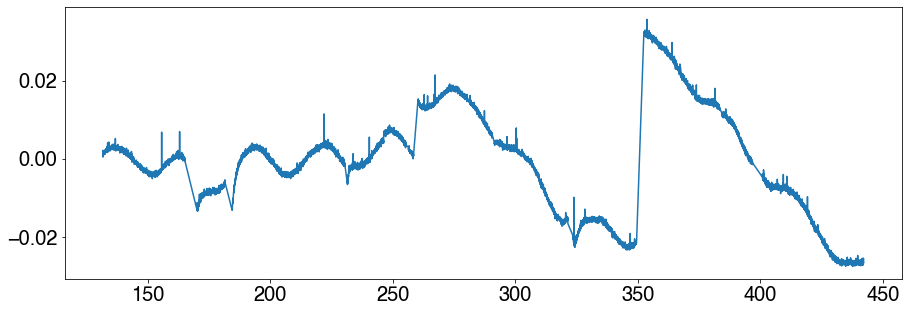

In [84]:
plt.figure(figsize=(15,5))
plt.plot(time_5d, flux_5d)

In [85]:
figure_five_d_PDC = combining_PDC_quarters('7590933')
flux_5d_PDC = figure_five_d_PDC[0]
time_5d_PDC = figure_five_d_PDC[1]
flux_error_5d_PDC = figure_five_d_PDC[2]

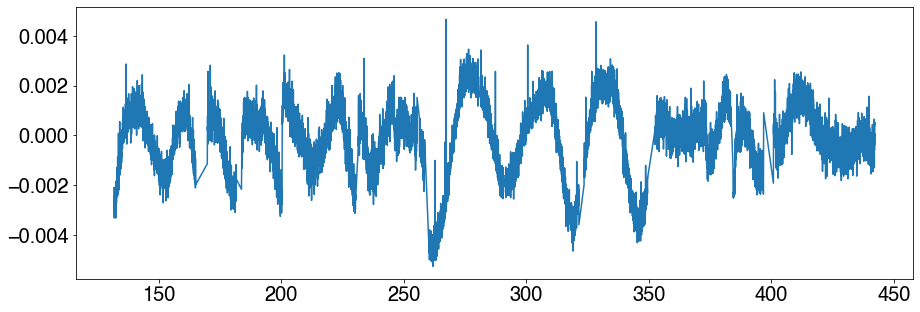

In [86]:
plt.figure(figsize=(15,5))
plt.plot(time_5d_PDC, flux_5d_PDC)

In [87]:
acf_fig5d = ac_mq_Q1_Q4_PDC('7590933', 1000);

Text(0.5, 1.0, 'Autocorrelated Figure 5d')

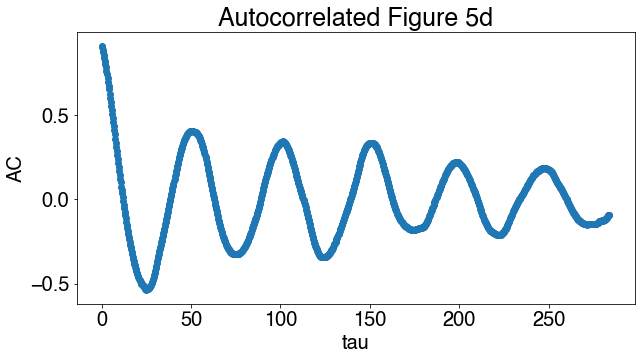

In [88]:
plt.figure(figsize=(10,5))
plt.scatter(acf_fig5d[1], acf_fig5d[0])
plt.xlabel('tau', fontsize = 20)
plt.ylabel('AC', fontsize = 20)
plt.title('Autocorrelated Figure 5d', fontsize = 25)

In [89]:
rotate_fig5d = ss.RotationModel(time_5d_PDC, flux_5d_PDC, flux_error_5d_PDC)

27.31317600786627


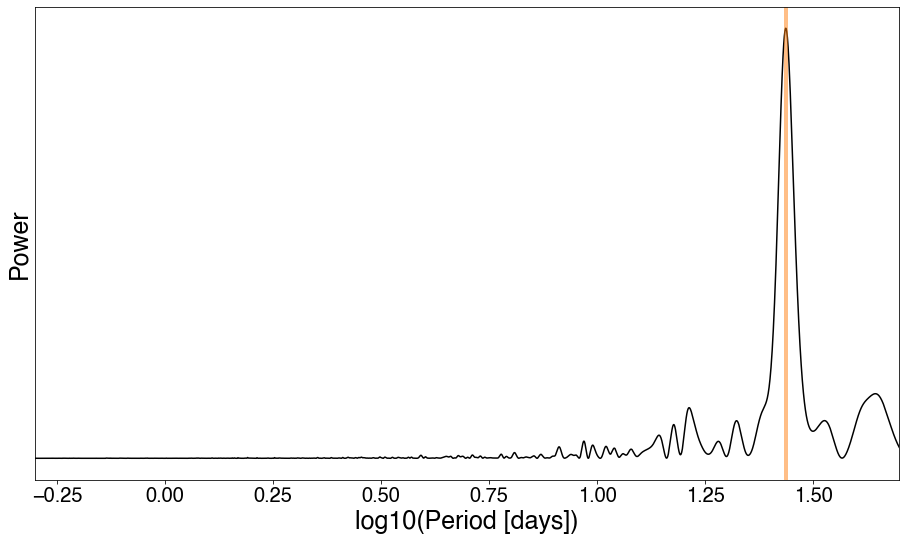

In [90]:
ls_period_5d = rotate_fig5d.ls_rotation()
print(ls_period_5d)
rotate_fig5d.ls_plot();

In [91]:
period_grid_5d = np.linspace(.1, 10, 1000)
pdm_period_5d, period_err_5d = rotate_fig5d.pdm_rotation(period_grid_5d, pdm_nbins=10)
print(pdm_period_5d, period_err_5d)

100%|██████████| 1000/1000 [00:09<00:00, 108.81it/s]

9.316216216216217 1.2042565654398305


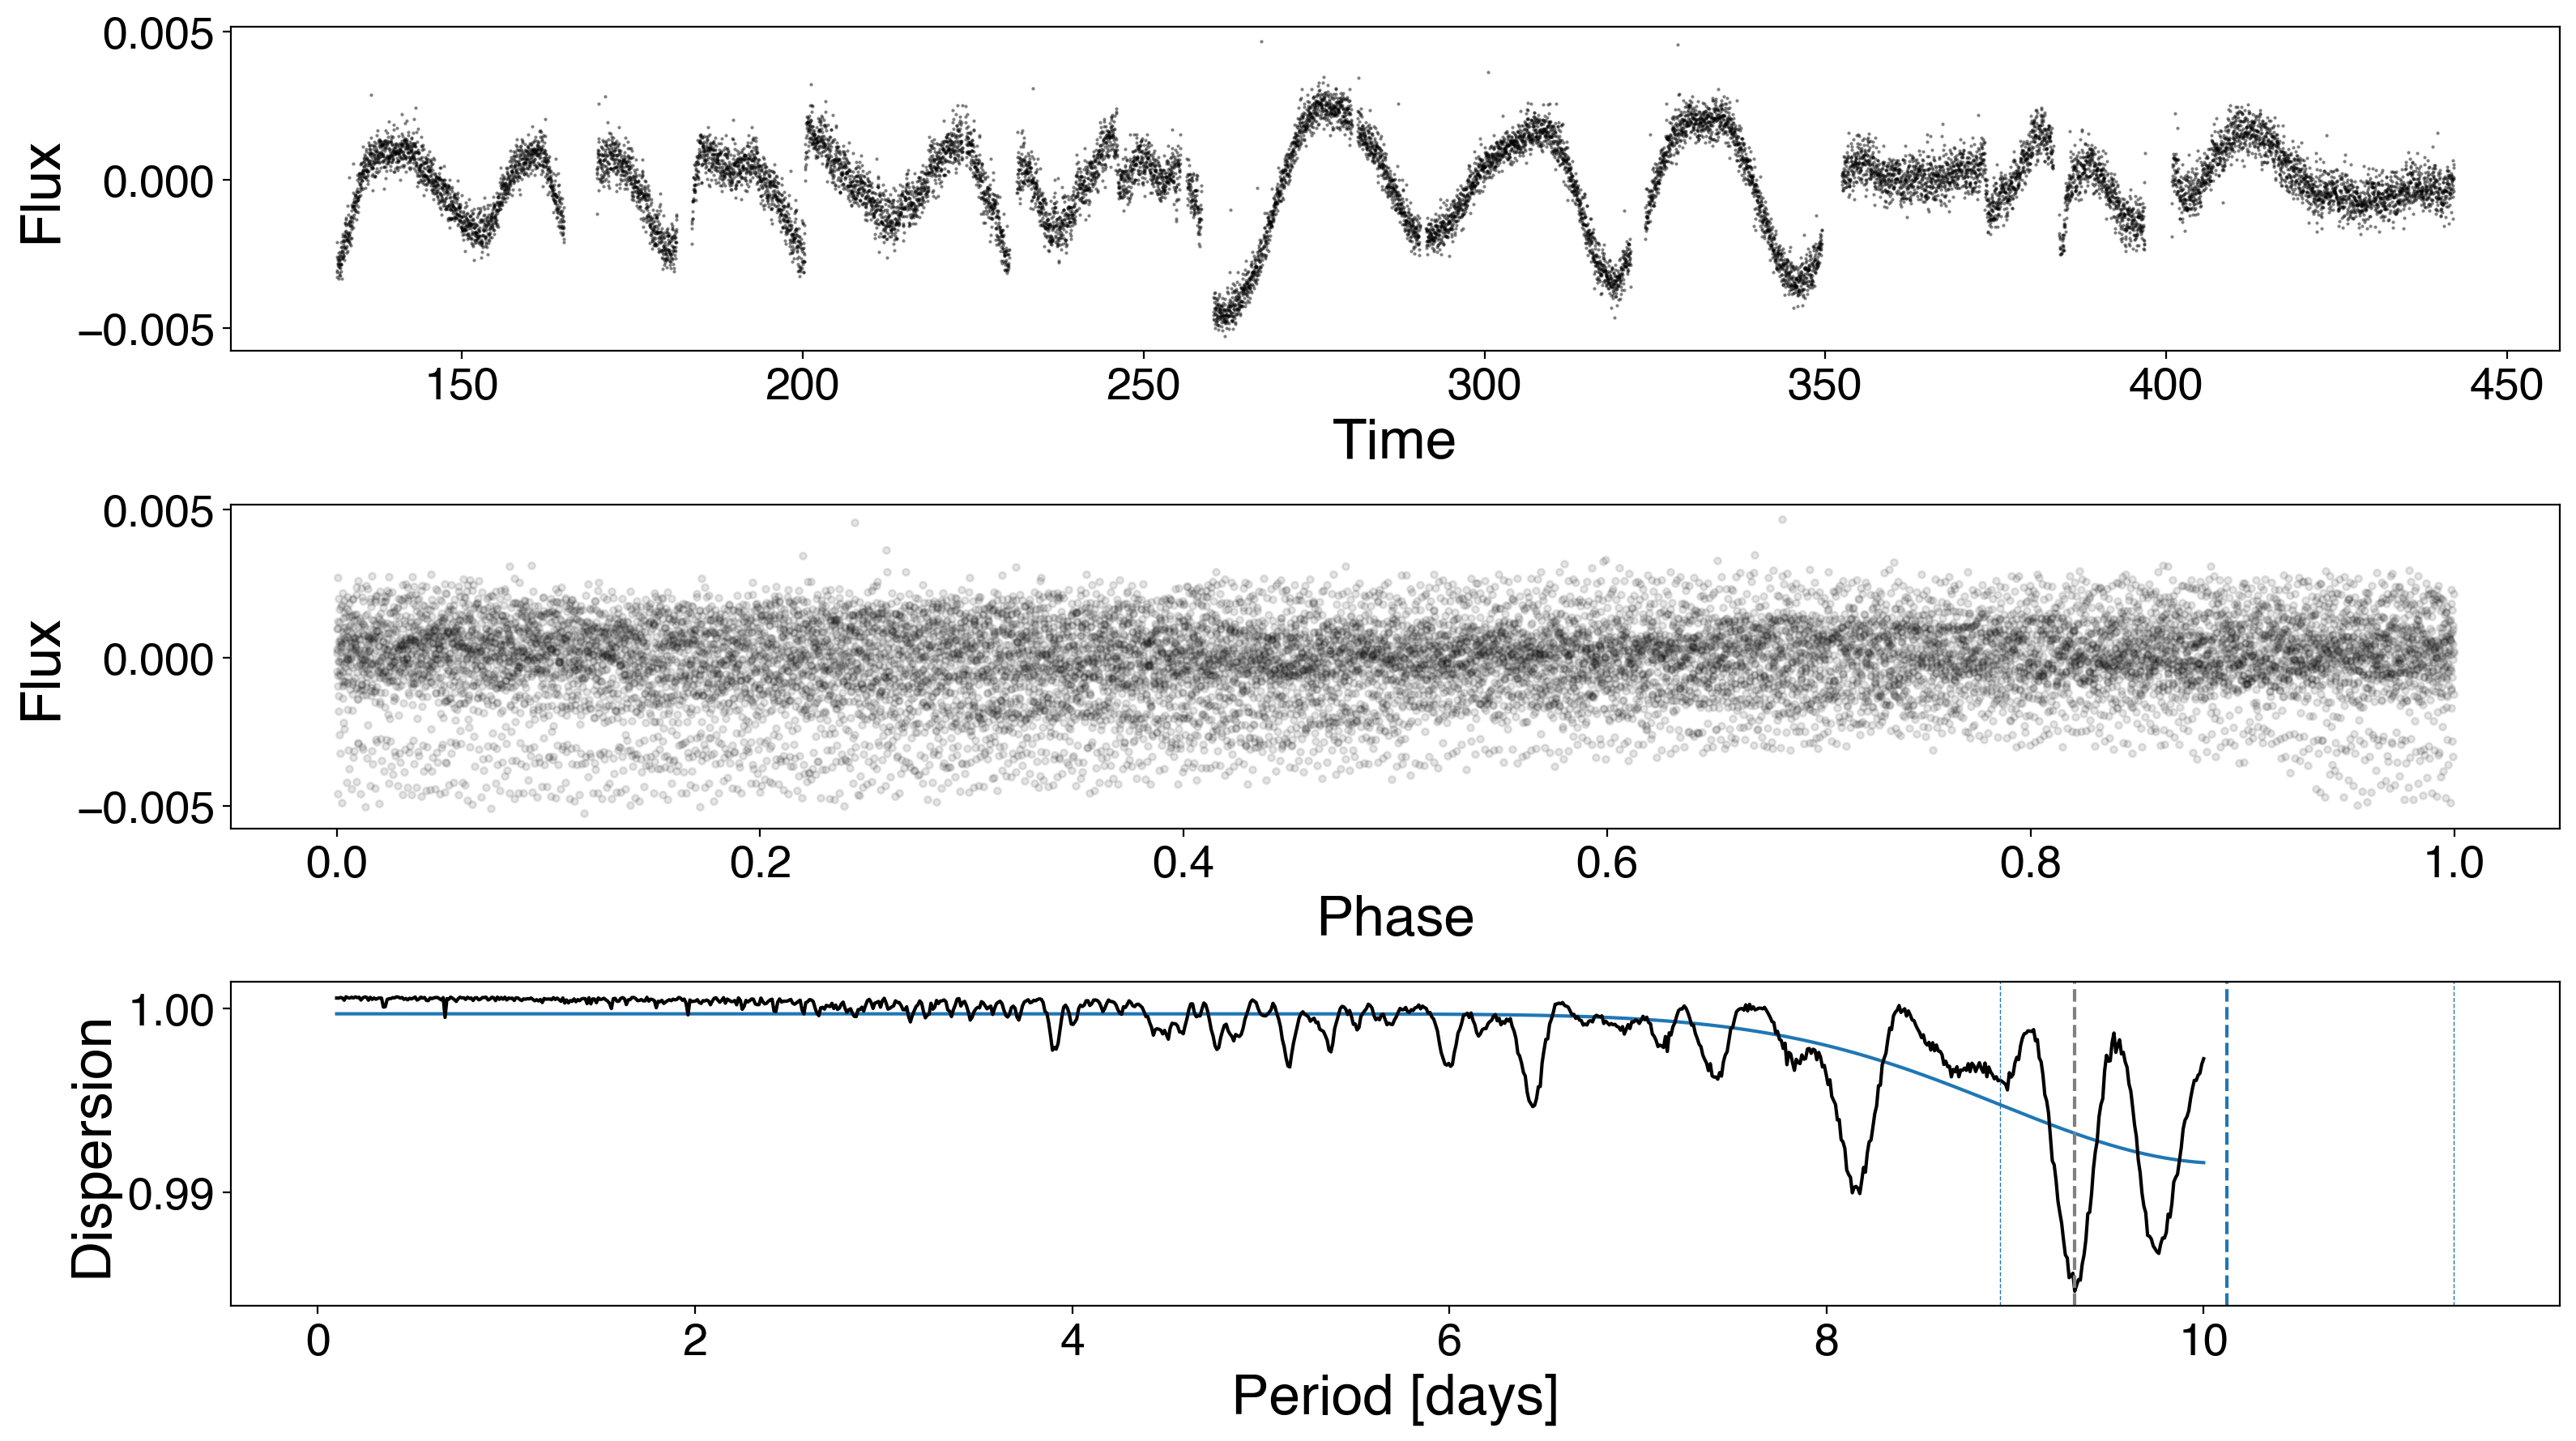

In [92]:
rotate_fig5d.pdm_plot();

# TESS Lightcurves for 5d

In [93]:
search_tess_5d = lk.search_targetpixelfile(target = "19:01:29.388+43:14:11.98", mission='TESS')

In [94]:
tess_5d = search_tess_5d.download_all(quality_bitmask='default')

/Users/ilanadoran/opt/anaconda3/lib/python3.7/site-packages/lightkurve/search.py:284: LightkurveWarning: Cannot download from an empty search result.
  LightkurveWarning)


In [95]:
search_result_IDd = lk.search_targetpixelfile(target = "7590933", mission='TESS')

In [96]:
tpf_IDd = search_result_IDc.download(quality_bitmask='default')

/Users/ilanadoran/opt/anaconda3/lib/python3.7/site-packages/lightkurve/search.py:225: LightkurveWarning: Cannot download from an empty search result.
  LightkurveWarning)


# Linear Interpolation

In [97]:
def linear_interpolation(flux, time):
    
    flux_interp = []
    time_interp = []

    for index, point in flux: 
        if math.isnan(point) == true:
            delty = np.abs(flux[point + 1] - flux[point - 1])/2
            deltx = np.abs(time[point + 1] - time[point - 1])/2 
        
            flux_new = flux[point - 1]  + delty
            time_new = time[index] + deltx
        
            flux_interp.append(flux_new)
            time_interp.append(time_new)
    
        else: 
            flux_interp.append(point)
            time_interp.append(time[index])
    
    return(flux_interp, time_interp)